# Obtaining the data

In [83]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [144]:
import pandas as pd
pd.set_option('display.max_columns', 50) 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob 
import seaborn as sns
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import itertools
import time
import xgboost as xgb

In [2]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Kickstarter*.csv')], ignore_index = True)

In [3]:
df.head(3)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,USD,1552539775,False,NaN,1.0,28000.0,2108505034,NaN,False,NaN,1548223375,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",Babalus Children's Shoes,NaN,"{""key"":""assets/023/667/205/a565fde5382d6b53276...",28645.0,"{""id"":3508024,""project_id"":3508024,""state"":""in...",babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",28645.0,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,USD,1504976459,False,NaN,1.0,1000.0,928751314,NaN,False,NaN,1502384459,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,NaN,"{""key"":""assets/017/766/989/dd9f18c773a8546d996...",1950.0,"{""id"":3094785,""project_id"":3094785,""state"":""ac...",the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1950.0,domestic
2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,USD,1371013395,False,NaN,1.0,15000.0,928014092,NaN,False,NaN,1368421395,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",NaN,"{""key"":""assets/011/433/681/489fd66f7861fefd8c8...",22404.0,"{""id"":359847,""project_id"":359847,""state"":""inac...",record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",22404.0,international


The resulting dataframe contains 209,222 projects.

In [4]:
len(df)

209222

# Scrubbing the data

In this section the data will be cleaned and pre-processed in order to allow for exploratory data analysis and modeling.

**Inspecting and dropping columns**

In [5]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

Description of each column:
- backers_count - number of people who contributed funds to the project
- blurb - short description of the project
- category - contains the category and sub-category of the project
- converted_pledged_amount - amount of money pledged, converted to the currency in the 'current_currency' column
- country - country the project creator is from
- created_at - date and time of when the project was initially created on Kickstarter
- creator - name of the project creator and other information about them, e.g. Kickstarter id number
- currency - original currency the project goal was denominated in
- currency_symbol - symbol of the original currency the project goal was denominated in
- currency_trailing_code - code of the original currency the project goal was denominated in
- current_currency - currency the project goal was converted to
- deadline - date and time of when the project will close for donations
- disable_communication - whether or not a project owner disabled communication with their backers
- friends - unclear (null or empty)
- fx_rate - foreign exchange rate between the original currency and the current_currency
- goal - funding goal
- id - id number of the project
- is_backing - unclear (null or false)
- is_starrable - whether or not a project can be starred (liked and saved) by users
- is_starred - whether or not a project has been starred (liked and saved) by users
- launched_at - date and time of when the project was launched for funding
- location - contains the town or city of the project creator
- name - name of the project
- permissions - unclear (null or empty)
- photo - contains a link and information to the project's photo/s
- pledged - amount pledged in the current_currency
- profile - details about the project's profile, including id number and various visual settings
- slug - name of the project with hyphens instead of spaces
- source_url - url for the project's category
- spotlight - after a project has been successful, it is spotlighted on the Kickstarter website
- staff_pick - whether a project was highlighted as a staff_pick when it was launched/live
- state - whether a project was successful, failed, canceled, suspending or still live
- state_changed_at - date and time of when a project's status was changed (same as the deadline for successful and failed projects)
- static_usd_rate - conversion rate between the original currency and USD
- urls - url to the project's page
- usd_pledged - amount pledged in USD
- usd_type - domestic or international

In [6]:
print(f"Of the {len(df)} projects in the dataset, there are {len(df[df.duplicated(subset='id')])} which are listed more than once.")

Of the 209222 projects in the dataset, there are 26958 which are listed more than once.


Duplicates are an issue in this dataset and will need to be dealt with. Further cleaning of the data will help clarify which duplicates, if any, need to be removed.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     o

Some columns contain very few nun-null entries, and can be dropped:

In [8]:
df.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=True)

Other columns are not useful for the purposes of this project, and can also be dropped for these reasons:

- converted_pledged_amount - most currencies are converted into USD in this column, but not all. Instead, the 'usd_pledged' column will be used as these all use the same currency (the dollar).
- creator - most projects are by different people, and so this cannot be usefully used to group or categorise projects, and is not useful in a machine learning context.
- currency - all currency values will be used as/converted to dollars, so that they can be evaluated together. It is not necessary to keep the original record because of this, and because it will be highly correlated with country (which will be kept).
- currency_symbol - as above.
- currency_trailing_code - as above.
- current_currency - as above.
- fx_rate - this is used to create 'converted_pledged_amount' from 'pledged', but does not always convert to dollars so can be dropped in favour of 'static_usd_rate' which always converts to dollars.
- photo - image processing/computer vision will not be used in this project.
- pledged - data in this column is stored in native currencies, so this will be dropped in favour of 'usd_pledged' which is all in the same currency (dollars).
- profile - this column contains a combination of information from other columns (e.g. id, state, dates, url).
- slug - this is simply the 'name' column with hyphens instead of spaces.
- source_url - the sites that the rows were each scraped from is not useful for building a model, as each is unique to an id.
- spotlight - projects can only be spotlighted after they are already successful, so this will be entirely correlated with successful projects.
- state_changed_at - this is the same as deadline for most projects. The only exceptions are for projects which were cancelled before their deadline, but they will not be included in this analysis.
- urls - as with source_url.
- usd_type - it is unclear what this column means, but it is unlikely to be necessary since all currency values will be converted to dollars, and other currency information has been dropped.

In [9]:
df.drop(['converted_pledged_amount', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
         'fx_rate', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state_changed_at', 'urls', 'usd_type'], axis=1, inplace=True)

**Converting datetime columns**

Columns containing dates are currently stored in unix time, and need to be converted to datetime. Because they have been converted from unix, all times are in UTC/GMT.

In [10]:
cols_to_convert = ['created_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c], origin='unix', unit='s')

In [11]:
print(f"The dataset contains projects added to Kickstarter between {min(df.created_at).strftime('%d %B %Y')} and {max(df.created_at).strftime('%d %B %Y')}.")

The dataset contains projects added to Kickstarter between 22 April 2009 and 14 March 2019.


Individual columns will now be pre-processed, and additional features engineered, where necessary.

Natural language processing is beyond the scope of this project. The length of the blurbs written by project creators will be calculated though, in case this is useful for the model (e.g. people preferring to read shorter or longer blurbs when choosing what to fund). The original blurb variable will then be dropped.

In [12]:
df['blurb_length'] = df['blurb'].str.split().str.len()

df.drop('blurb', axis=1, inplace=True)

**Category**

The category variable is currently stored as a string, although it was clearly originally a dictionary. The example below shows that each project has both a category (e.g. games) and a sub-category (e.g. tabletop games). Both will be extracted.

In [13]:
df.iloc[0]['category']

'{"id":266,"name":"Footwear","slug":"fashion/footwear","position":5,"parent_id":9,"color":16752598,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/fashion/footwear"}}}'

In [14]:
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)

f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

In [15]:
print(f"There are {df.category.nunique()} unique categories and {df.sub_category.nunique()} unique sub-categories.")

There are 15 unique categories and 145 unique sub-categories.


**Disable_communication**

99.7% of project owners did not disable communication with their backers (unsurprisingly). Because nearly all projects have the same value for this variable, it will be dropped as it does not provide much information.

In [16]:
df.disable_communication.value_counts(normalize=True)

disable_communication
False    0.997022
True     0.002978
Name: proportion, dtype: float64

In [17]:
df.drop('disable_communication', axis=1, inplace=True)

**Goal**

The goal amount of funding for each project is currently recorded in native currencies. In order to allow for fair comparisons between projects, goals will be converted into dollars (as amount pledged already is).

In [18]:
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [19]:
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

**Is_starrable**

Only 3.3% of projects were starrable by users. Although this is only a very small proportion, whether or not a project was liked and saved by users is likely to be informative about whether or not a project was successful, so the variable will be kept for now and assessed again once irrelevant rows have been dropped, to check it is still useful.

In [20]:
df.is_starrable.value_counts(normalize=True)

is_starrable
False    0.967403
True     0.032597
Name: proportion, dtype: float64

**Location**

The location field contains the town/city that a project originates from, as well as the country. There are a large number (15,235) of unique locations. Because the country is already recorded separately in the country field, and there are such a large number of unique categories (making one-hot encoding not useful, particularly as there are likely to be a lot of smaller towns and cities with very few projects), the column will be dropped.

In [21]:
df.iloc[0]['location']

'{"id":2462429,"name":"Novato","slug":"novato-ca","short_name":"Novato, CA","displayable_name":"Novato, CA","localized_name":"Novato","country":"US","state":"CA","type":"Town","is_root":false,"urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/novato-ca","location":"https://www.kickstarter.com/locations/novato-ca"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1552595066.49b64db66a5124f5831752d055cd09aff20cc652&woe_id=2462429"}}}'

In [23]:
df.location.nunique()

15235

In [24]:
df.drop('location', axis=1, inplace=True)

**Name**

The length of project names will be calculated, in case this is useful for the model. The original name variable will then be dropped.

In [25]:
df['name_length'] = df['name'].str.split().str.len()
df.drop('name', axis=1, inplace=True)

**Usd_pledged**

This column requires rounding to two decimal places.

In [26]:
df['usd_pledged'] = round(df['usd_pledged'],2)

**Additional calculated features**

Additional features can be calculated from the existing features, which may also help to predict whether a project is successfully funded. The features to be added are: time from creation to launch, campaign length, launch day of week, deadline day of week, launch month, deadline month, launch time of day, deadline time of day and mean pledge per backer. Original datetime values and the mean pledge per backer will be kept in for now for EDA purposes, but will be removed later, before modeling.

In [ ]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days 

# Launch day of week
df['launch_day'] = df['launched_at'].dt.day_name()

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.day_name()

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [30]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour 

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) 

df.drop('launch_hour', axis=1, inplace=True)

In [31]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour 

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

In [32]:
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

**Checking for null values**

In [33]:
df.isna().sum()

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   8
sub_category                   0
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
dtype: int64

There are eight projects without a blurb_length, i.e. without a blurb. These can be replaced with a length of 0.

In [34]:
df.blurb_length.fillna(0, inplace=True)

/var/folders/y6/hjxs6d715_z8qgfmk_s0w7t00000gn/T/ipykernel_41446/1047004766.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.blurb_length.fillna(0, inplace=True)


In [35]:
df.isna().sum().sum()

18362

**Dropping rows**

This project aims to predict whether projects succeed or fail. The dataset also includes canceled, live (i.e. not yet finished) and suspended projects. These will now be removed.

In [36]:
df.state.value_counts()

state
successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: count, dtype: int64

In [37]:
# Dropping projects which are not successes or failures
df = df[df['state'].isin(['successful', 'failed'])]

In [38]:
# Confirming that the most recent deadline is the day on which the data was scraped, i.e. there are no projects which have yet to be resolved into either successes or failures
max(df.deadline)

Timestamp('2019-03-14 04:06:01')

**Dropping duplicates**

As demonstrated above, some projects are included in the dataset more than once. Duplicates will now be assessed and removed.

In [39]:
duplicates = df[df.duplicated(subset='id')]
print(f"Of the {len(df)} projects in the dataset, there are {len(df[df.duplicated(subset='id')])} which are listed more than once.")
print(f"Of these, {len(df[df.duplicated()])} have every value in common between duplicates.")

Of the 192664 projects in the dataset, there are 23685 which are listed more than once.
Of these, 23674 have every value in common between duplicates.


In [40]:
# Dropping duplicates which have every value in common
df.drop_duplicates(inplace=True)

In [41]:
len(df)

168990

In [42]:
print(len(df[df.duplicated(subset='id')]), "duplicated projects remain.")
duplicated = df[df.duplicated(subset='id', keep=False)].sort_values(by='id')
duplicated

11 duplicated projects remain.


,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer
20854,1675,games,NZ,2018-05-30 04:51:55,2018-12-18 04:00:00,122079667,False,2018-11-21 02:04:29,False,successful,200537.60,12.0,tabletop games,342.10,4,175,27,Wednesday,Tuesday,November,December,2am-4am,4am-6am,119.72
172178,1675,games,NZ,2018-05-30 04:51:55,2018-12-18 04:00:00,122079667,False,2018-11-21 02:04:29,False,successful,200710.36,12.0,tabletop games,342.40,4,175,27,Wednesday,Tuesday,November,December,2am-4am,4am-6am,119.83
118074,32,art,CA,2018-05-07 22:52:48,2018-05-30 01:00:00,123735637,False,2018-05-08 01:43:43,False,successful,669.56,13.0,illustration,466.97,10,0,22,Tuesday,Wednesday,May,May,12am-2am,12am-2am,20.92
160300,32,art,CA,2018-05-07 22:52:48,2018-05-30 01:00:00,123735637,False,2018-05-08 01:43:43,False,successful,669.10,13.0,illustration,466.65,10,0,22,Tuesday,Wednesday,May,May,12am-2am,12am-2am,20.91
124931,18,photography,FR,2017-11-06 23:50:45,2018-01-06 02:53:04,299750696,False,2017-12-02 02:53:04,False,successful,1654.77,18.0,photobooks,1423.46,8,25,35,Saturday,Saturday,December,January,2am-4am,2am-4am,91.93
45253,18,photography,FR,2017-11-06 23:50:45,2018-01-06 02:53:04,299750696,False,2017-12-02 02:53:04,False,successful,1661.61,18.0,photobooks,1429.34,8,25,35,Saturday,Saturday,December,January,2am-4am,2am-4am,92.31
165662,779,games,CA,2018-12-23 02:00:22,2019-03-02 03:00:00,395324593,False,2019-01-29 00:02:43,False,successful,10222.68,17.0,tabletop games,151.33,7,37,32,Tuesday,Saturday,January,March,12am-2am,2am-4am,13.12
122419,779,games,CA,2018-12-23 02:00:22,2019-03-02 03:00:00,395324593,False,2019-01-29 00:02:43,False,successful,10231.08,17.0,tabletop games,151.46,7,37,32,Tuesday,Saturday,January,March,12am-2am,2am-4am,13.13
62993,5,technology,HK,2018-03-15 11:39:29,2018-04-27 02:09:50,1188888346,False,2018-03-28 02:09:50,False,successful,1437.92,20.0,gadgets,1274.30,11,13,30,Wednesday,Friday,March,April,2am-4am,2am-4am,287.58
66791,5,technology,HK,2018-03-15 11:39:29,2018-04-27 02:09:50,1188888346,False,2018-03-28 02:09:50,False,successful,1437.70,20.0,gadgets,1274.10,11,13,30,Wednesday,Friday,March,April,2am-4am,2am-4am,287.54


Comparing rows for each duplicated project:

In [44]:
dup_ids = duplicated.id.unique()
for i in dup_ids:
    index1 = duplicated[duplicated.id == i][:1].index.values
    index2 = duplicated[duplicated.id == i][1:2].index.values
    print(index1, index2)


[20854] [172178]
[118074] [160300]
[124931] [45253]
[165662] [122419]
[62993] [66791]
[101074] [34827]
[154822] [14546]
[21153] [40924]
[123041] [132955]
[15470] [146321]
[106904] [207865]


In [ ]:
df.loc[124657] == df.loc[106307]

backers_count               True
category                    True
country                     True
created_at                  True
deadline                    True
id                          True
is_starrable                True
launched_at                 True
staff_pick                  True
state                       True
usd_pledged                False
blurb_length                True
sub_category                True
usd_goal                   False
name_length                 True
creation_to_launch_days     True
campaign_days               True
launch_day                  True
deadline_day                True
launch_month                True
deadline_month              True
launch_time                 True
deadline_time               True
pledge_per_backer          False
dtype: bool

In [ ]:
df.loc[105017] == df.loc[191946]

backers_count               True
category                    True
country                     True
created_at                  True
deadline                    True
id                          True
is_starrable                True
launched_at                 True
staff_pick                  True
state                       True
usd_pledged                False
blurb_length                True
sub_category                True
usd_goal                   False
name_length                 True
creation_to_launch_days     True
campaign_days               True
launch_day                  True
deadline_day                True
launch_month                True
deadline_month              True
launch_time                 True
deadline_time               True
pledge_per_backer          False
dtype: bool

In [46]:
df.loc[39735] == df.loc[102505]

backers_count              False
category                   False
country                     True
created_at                 False
deadline                   False
id                         False
is_starrable                True
launched_at                False
staff_pick                  True
state                       True
usd_pledged                False
blurb_length               False
sub_category               False
usd_goal                   False
name_length                False
creation_to_launch_days    False
campaign_days               True
launch_day                 False
deadline_day               False
launch_month               False
deadline_month             False
launch_time                False
deadline_time              False
pledge_per_backer          False
dtype: bool

In [47]:
df.loc[31755] == df.loc[84748]

backers_count              False
category                   False
country                     True
created_at                 False
deadline                   False
id                         False
is_starrable                True
launched_at                False
staff_pick                  True
state                      False
usd_pledged                False
blurb_length                True
sub_category               False
usd_goal                   False
name_length                False
creation_to_launch_days    False
campaign_days              False
launch_day                  True
deadline_day               False
launch_month               False
deadline_month             False
launch_time                False
deadline_time              False
pledge_per_backer          False
dtype: bool

In [48]:
df.loc[204234] == df.loc[69815]

backers_count              False
category                   False
country                    False
created_at                 False
deadline                   False
id                         False
is_starrable                True
launched_at                False
staff_pick                 False
state                      False
usd_pledged                False
blurb_length               False
sub_category               False
usd_goal                   False
name_length                False
creation_to_launch_days    False
campaign_days              False
launch_day                  True
deadline_day               False
launch_month               False
deadline_month             False
launch_time                False
deadline_time              False
pledge_per_backer          False
dtype: bool

In [49]:
df.loc[165028] == df.loc[2380]

backers_count              False
category                   False
country                     True
created_at                 False
deadline                   False
id                         False
is_starrable                True
launched_at                False
staff_pick                  True
state                      False
usd_pledged                False
blurb_length               False
sub_category               False
usd_goal                   False
name_length                False
creation_to_launch_days    False
campaign_days              False
launch_day                 False
deadline_day               False
launch_month               False
deadline_month             False
launch_time                False
deadline_time              False
pledge_per_backer          False
dtype: bool

In [ ]:
df.loc[103127] == df.loc[63824]

backers_count               True
category                    True
country                     True
created_at                  True
deadline                    True
id                          True
is_starrable                True
launched_at                 True
staff_pick                  True
state                       True
usd_pledged                False
blurb_length                True
sub_category                True
usd_goal                   False
name_length                 True
creation_to_launch_days     True
campaign_days               True
launch_day                  True
deadline_day                True
launch_month                True
deadline_month              True
launch_time                 True
deadline_time               True
pledge_per_backer          False
dtype: bool

In [51]:
df.loc[165952] == df.loc[58250]

backers_count              False
category                   False
country                    False
created_at                 False
deadline                   False
id                         False
is_starrable                True
launched_at                False
staff_pick                  True
state                      False
usd_pledged                False
blurb_length               False
sub_category               False
usd_goal                   False
name_length                False
creation_to_launch_days    False
campaign_days              False
launch_day                 False
deadline_day               False
launch_month               False
deadline_month             False
launch_time                False
deadline_time              False
pledge_per_backer          False
dtype: bool

In [52]:
df.loc[94567] == df.loc[184176]

backers_count              False
category                    True
country                    False
created_at                 False
deadline                   False
id                         False
is_starrable                True
launched_at                False
staff_pick                  True
state                      False
usd_pledged                False
blurb_length               False
sub_category               False
usd_goal                   False
name_length                False
creation_to_launch_days    False
campaign_days              False
launch_day                 False
deadline_day               False
launch_month               False
deadline_month             False
launch_time                False
deadline_time              False
pledge_per_backer          False
dtype: bool

The results above show that for each pair of duplicates, there are differences in the usd_pledge and usd_goal columns. The differences are only in the order of a few cents or dollars, so it does not make much difference which one is kept. Therefore the first one of each pair will be dropped.

In [53]:
df.drop_duplicates(subset='id', keep='first', inplace=True)

**Setting the index**

The id will now be set as the index.

In [54]:
df.set_index('id', inplace=True)
df.head()

,backers_count,category,country,created_at,deadline,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer
id,,,,,,,,,,,,,,,,,,,,,,,
928751314,47,games,US,2017-08-02 14:28:13,2017-09-09 17:00:59,False,2017-08-10 17:00:59,False,successful,1950.00,22.0,playing cards,1000.00,4,8,30,Thursday,Saturday,August,September,4pm-6pm,4pm-6pm,41.49
928014092,271,music,US,2012-09-30 06:45:33,2013-06-12 05:03:15,False,2013-05-13 05:03:15,False,successful,22404.00,15.0,rock,15000.00,7,225,30,Monday,Wednesday,May,June,4am-6am,4am-6am,82.67
596091328,3,games,GB,2017-01-07 09:11:11,2017-03-13 17:22:56,False,2017-01-12 18:22:56,False,failed,165.38,23.0,playing cards,12160.66,8,5,60,Thursday,Monday,January,March,6pm-8pm,4pm-6pm,55.13
998516049,3,publishing,US,2012-12-06 18:04:31,2013-01-09 20:32:07,False,2012-12-10 20:32:07,False,successful,2820.00,24.0,nonfiction,2800.00,7,4,30,Monday,Wednesday,December,January,8pm-10pm,8pm-10pm,940.00
1224600291,35,music,US,2014-10-24 17:35:50,2015-05-02 02:25:46,False,2015-04-02 02:25:46,False,successful,3725.00,18.0,classical music,3500.00,4,159,30,Thursday,Saturday,April,May,2am-4am,2am-4am,106.43


***
# Exploring the data

In this section, exploratory data analysis will be conducted, in order to explore the data and draw useful insights.

**Key statistics**

In [55]:
df.describe()

,backers_count,created_at,deadline,launched_at,usd_pledged,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,pledge_per_backer
count,168979.000000,168979,168979,168979,1.689790e+05,168979.000000,1.689790e+05,168979.000000,168979.000000,168979.000000,154158.000000
mean,140.068221,2015-10-24 19:34:30.667893504,2016-01-12 04:14:29.242905856,2015-12-10 12:33:32.052598272,1.211097e+04,19.010759,4.109688e+04,5.709153,46.710645,32.643287,78.737594
min,0.000000,2009-04-22 02:11:10,2009-05-03 06:59:59,2009-04-24 19:52:03,0.000000e+00,0.000000,1.000000e-02,1.000000,0.000000,1.000000,0.460000
25%,3.000000,2014-07-31 03:52:35.500000,2014-10-21 09:27:55.500000,2014-09-18 18:48:55.500000,1.000000e+02,16.000000,1.500000e+03,4.000000,3.000000,30.000000,27.140000
50%,25.000000,2015-10-24 20:50:05,2016-01-09 01:35:00,2015-12-05 05:05:30,1.457000e+03,20.000000,5.000000e+03,6.000000,11.000000,30.000000,50.550000
75%,85.000000,2017-05-28 23:59:45.500000,2017-08-14 20:20:53.500000,2017-07-12 21:49:29,6.235000e+03,22.000000,1.329770e+04,8.000000,36.000000,34.000000,89.300000
max,105857.000000,2019-03-04 22:27:12,2019-03-14 04:06:01,2019-03-06 05:07:40,8.596475e+06,35.000000,1.523501e+08,27.000000,3304.000000,93.000000,10000.000000
std,894.931802,NaN,NaN,NaN,8.373929e+04,4.982463,1.110957e+06,2.706210,127.597384,11.761523,140.809792


In [56]:
print("Key stats:")
print("\nThe total amount of money that projects have aimed to raise is ${0:,.0f}".format(df.usd_goal.sum()))
print("The total amount of money pledged by backers is ${0:,.0f}".format(df.usd_pledged.sum()))
print("The total amount of money pledged by backers to successful projects is ${0:,.0f}".format(sum(df.loc[df['state'] == 'successful'].usd_pledged)))

print("\nThe total number of successful or failed projects launched on Kickstarter is: {0:,}".format(len(df)))
print("The total number of projects which were successfully funded is: {0:,}".format(len(df.loc[df['state'] == 'successful'])))
print(f"The proportion of completed projects which were successfully funded is: {int(round((len(df.loc[df['state'] == 'successful'])/len(df))*100,0))}%")

print("\nThe mean project fundraising goal is ${0:,.0f}".format(df.usd_goal.mean()))
print("The mean amount pledged per project is ${0:,.0f}".format(df.usd_pledged.mean()))
print("The mean amount pledged per successful project is ${0:,.0f}".format(df.loc[df['state'] == 'successful'].usd_pledged.mean()))
print("The mean amount pledged per failed project is ${0:,.0f}".format(df.loc[df['state'] == 'failed'].usd_pledged.mean()))
      
print("\nThe mean number of backers per project is", int(round(df.backers_count.mean(),0)))
print("The mean pledge per backer is ${0:,.0f}".format(df.pledge_per_backer.mean()))
print("The mean number of days a campaign is run for is", int(round(df.campaign_days.mean(),0)))

Key stats:

The total amount of money that projects have aimed to raise is $6,944,509,002
The total amount of money pledged by backers is $2,046,499,506
The total amount of money pledged by backers to successful projects is $1,965,320,747

The total number of successful or failed projects launched on Kickstarter is: 168,979
The total number of projects which were successfully funded is: 94,779
The proportion of completed projects which were successfully funded is: 56%

The mean project fundraising goal is $41,097
The mean amount pledged per project is $12,111
The mean amount pledged per successful project is $20,736
The mean amount pledged per failed project is $1,094

The mean number of backers per project is 140
The mean pledge per backer is $79
The mean number of days a campaign is run for is 33


**How do succesful and failed projects differ?**

The graphs below show how various features differ between failed and successful projects.
- Unsurprisingly, successful projects tend to have smaller (and therefore more realistic) goals - the median amount sought by successful projects is about half that of failed projects.
- The differences in the median amount pledged per project are more surprising. The median amount pledged per successful project is considerably higher than the median amount requested, suggesting that projects that meet their goal tend to go on to gain even more funding, and become 'over-funded'.
- On a related note, the difference between failed and successful companies is much larger in terms of amount pledged and the number of backers, compared to goal amount. Probably once potential backers see that a project looks like it will be successful, they are much more likely to jump on the bandwagon and fund it.
- Successful projects have slightly shorter durations.
- Successful projects tend to take slightly longer to launch, measured from the time the project was first created on the site.
- Average name and blurb lengths are very similar between failed and successful projects.
- Roughly 20% of successful projects were highlighted on the site as staff picks. It does not seem unreasonable to suggest a causative relationship here, i.e. that projects that are chosen as staff picks are much more likely to go on to be successful, and that only a few staff picks go on to fail. This measurement is possibly polluted by the point at which a project is chosen as a staff pick, however - e.g. a project may already have some backers and funding when it is chosen as a staff pick.

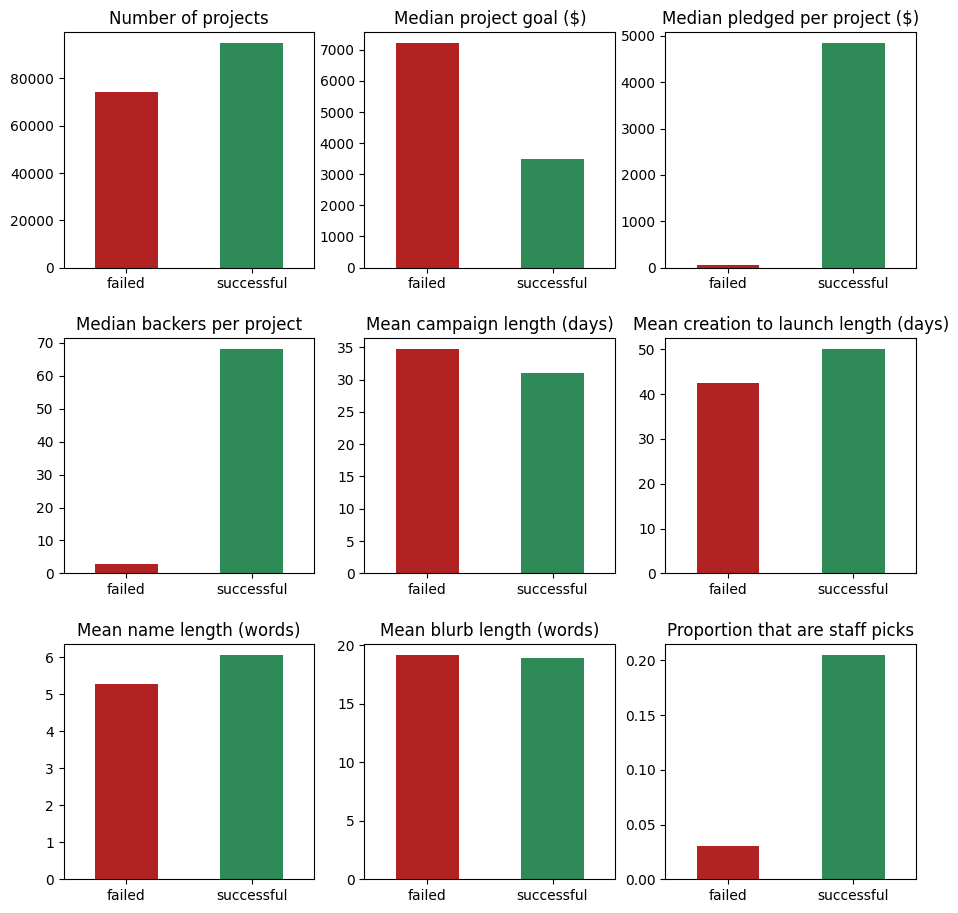

In [78]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(11,11))

df['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

df.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

df.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

df.groupby('state').creation_to_launch_days.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

df.groupby('state').name_length.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
ax7.set_title('Mean name length (words)')
ax7.set_xlabel('')

df.groupby('state').blurb_length.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
ax8.set_title('Mean blurb length (words)')
ax8.set_xlabel('')

pick_df = pd.get_dummies(df.set_index('staff_pick').state).groupby('staff_pick').sum()
(pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 
ax9.set_title('Proportion that are staff picks')
ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

**How has fundraising changed over time?**

The graph below shows the number of projects launched each month on Kickstarter from 2009 to 2019.
- The number of projects steadily grows from when the company was founded in 2009 up to the start of 2014.
- From 2012 Kickstarter started expanding into other countries, having launched initially in the US.
- Growth increased dramatically in 2014, and has remained at a high level since then, with a small decrease from 2015 to 2016.
- Seasonality is also hinted at, with fewer projects appearing to be launched in November.
- The second graph shows a similar story, with the cumulative amount pledged increasing more quickly from 2012 onwards.

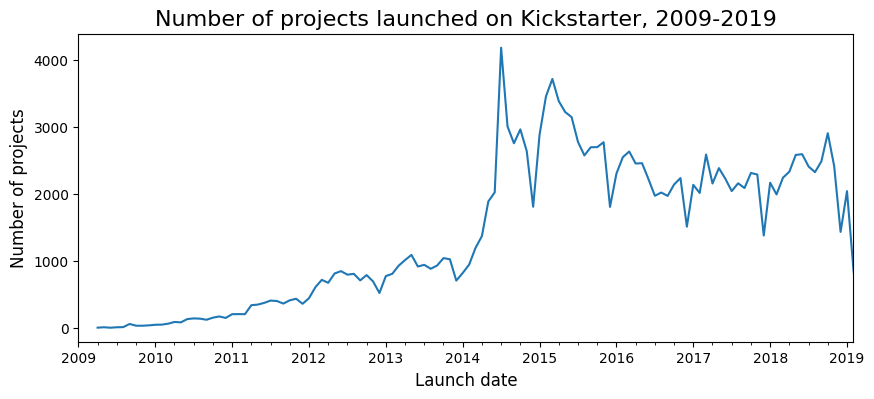

In [80]:
# Plotting the number of projects launched each month
plt.figure(figsize=(10,4))
df.set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2019-02-28')
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)
plt.title('Number of projects launched on Kickstarter, 2009-2019', fontsize=16)
plt.show()

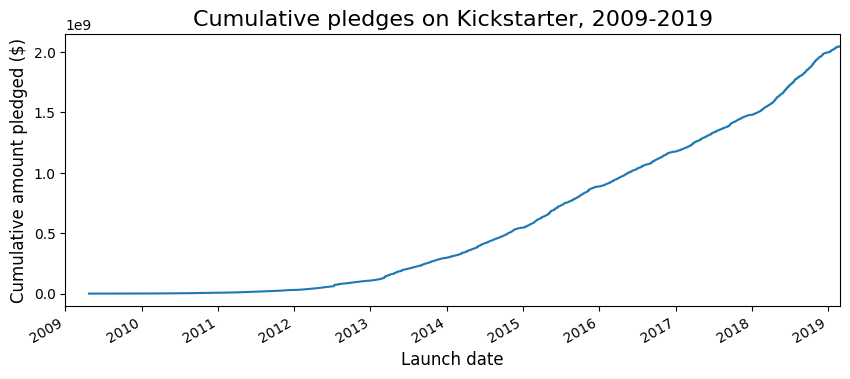

In [81]:
# Plotting the cumulative amount pledged on Kickstarter
plt.figure(figsize=(10,4))
df.set_index('launched_at').sort_index().usd_pledged.cumsum().plot()
plt.xlim('2009-01-01', '2019-02-28')
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Cumulative amount pledged ($)', fontsize=12)
plt.title('Cumulative pledges on Kickstarter, 2009-2019', fontsize=16)
plt.show()

The table and graph below show the total and distribution of pledged amounts for each year 2009-2019. Again, the trend can be split into two phases, with a change in 2014. From 2014 onwards there was greater variation in the amounts pledged, with lower median amounts than the period 2009-2014, but generally higher mean amounts (with the exception of 2013) due to some very large projects.

In [60]:
print("Average amount pledged per project in each year, in $:")
print(round(df.set_index('launched_at').usd_pledged.resample('YS').mean(),2))

Average amount pledged per project in each year, in $:
launched_at
2009-01-01     3683.34
2010-01-01     4723.06
2011-01-01     5656.52
2012-01-01     9140.69
2013-01-01    17151.15
2014-01-01     9707.05
2015-01-01     9703.89
2016-01-01    10933.94
2017-01-01    11783.67
2018-01-01    18503.01
2019-01-01    17200.14
Freq: YS-JAN, Name: usd_pledged, dtype: float64


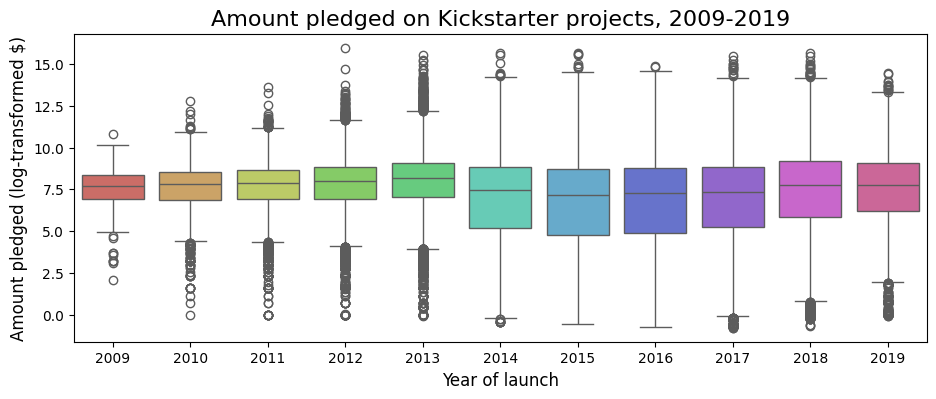

In [84]:
# Plotting the distribution of pledged amounts each year
plt.figure(figsize=(11,4))
sns.boxplot(x=df.launched_at.dt.year, y=np.log(df.usd_pledged), palette='hls')
plt.xlabel('Year of launch', fontsize=12)
plt.ylabel('Amount pledged (log-transformed $)', fontsize=12)
plt.title('Amount pledged on Kickstarter projects, 2009-2019', fontsize=16)
plt.show()

The table and graph below are similar to the ones above, but for the goals of each project. The changes in goals show a similar pattern to the changes in the amounts pledged.

In [85]:
print("Average fundraising goal per project in each year, in $:")
print(round(df.set_index('launched_at').usd_goal.resample('YS').mean(),2))

Average fundraising goal per project in each year, in $:
launched_at
2009-01-01     3937.43
2010-01-01     5158.64
2011-01-01     6242.00
2012-01-01     9479.75
2013-01-01    14234.51
2014-01-01    40728.63
2015-01-01    68779.14
2016-01-01    50276.93
2017-01-01    49719.64
2018-01-01    19859.10
2019-01-01    16321.28
Freq: YS-JAN, Name: usd_goal, dtype: float64


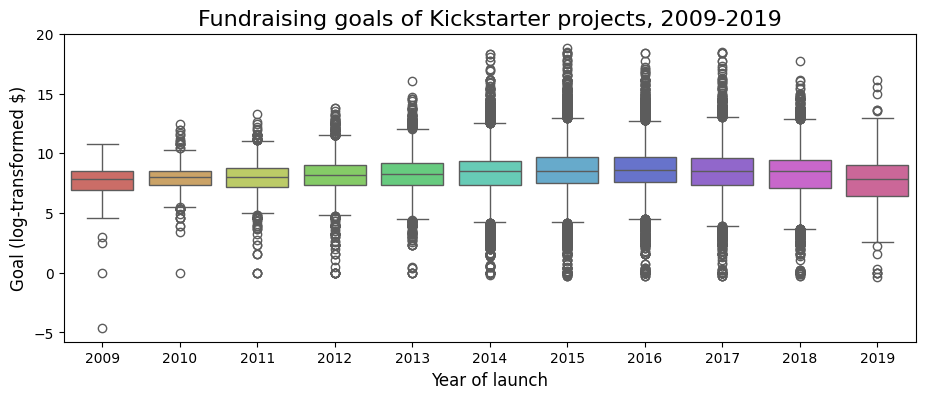

In [89]:
# Plotting the distribution of goal amounts each year
plt.figure(figsize=(11,4))
sns.boxplot(x=df.launched_at.dt.year, y=np.log(df.usd_goal), palette='hls')
plt.xlabel('Year of launch', fontsize=12)
plt.ylabel('Goal (log-transformed $)', fontsize=12)
plt.title('Fundraising goals of Kickstarter projects, 2009-2019', fontsize=16)
plt.show()

The graph below shows the number and proportion of failed and successful projects each year. Once again, there is a change from 2014. From 2009 to 2013, each year about 80% of projects were successful. However, this decreased from 2014, although since then it has mostly been rising again. 

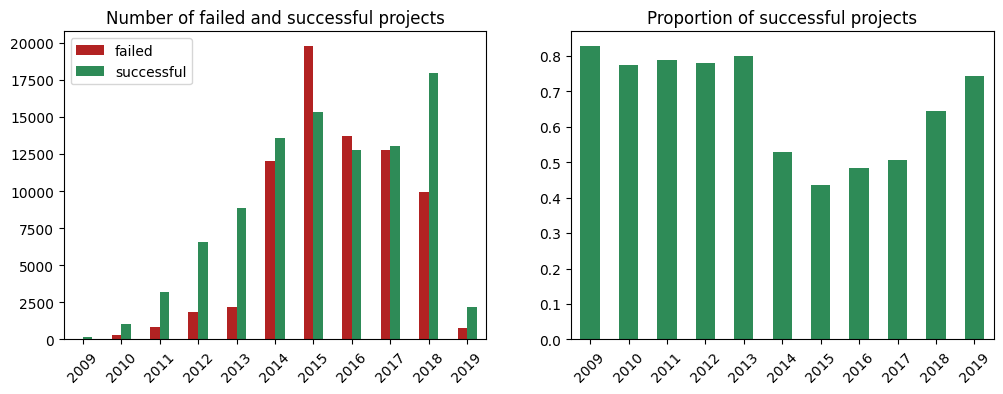

In [90]:
year_df = df.set_index('launched_at').state
year_df = pd.get_dummies(year_df).resample('YS').sum()

fig, ax = plt.subplots(1,2, figsize=(12,4))

year_df.plot.bar(ax=ax[0], color=['firebrick', 'seagreen'])
ax[0].set_title('Number of failed and successful projects')
ax[0].set_xlabel('')
ax[0].set_xticklabels(list(range(2009,2020)), rotation=45)

year_df.div(year_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax[1], color='seagreen')
ax[1].set_title('Proportion of successful projects')
ax[1].set_xlabel('')
ax[1].set_xticklabels(list(range(2009,2020)), rotation=45)

plt.show()

**What types of projects do people launch and which are more successful?**

- There are 15 project categories, of which music is the most common, followed by film & video and art.
- Technology projects have the highest goals by far (in terms of their median goal size), followed by food (e.g. funding for restaurants), with other categories generally much smaller in terms of their funding goals.
- However, technology projects are towards the bottom of the leaderboard in terms of the median amount actually pledged.
- Games, comics, dance and design projects obtain the greatest amount of funding, on average (median).
- The most frequently succesful categories are comics and dance (probably at least partly due to their relatively small funding goals), while the least successful are food, journalism and technology (again, probably because of their large funding goals). 
- Comics and games tend to attract the most backers, but each backer tends to pledge less.
- Dance and film & video tend to attract the most generous backers.

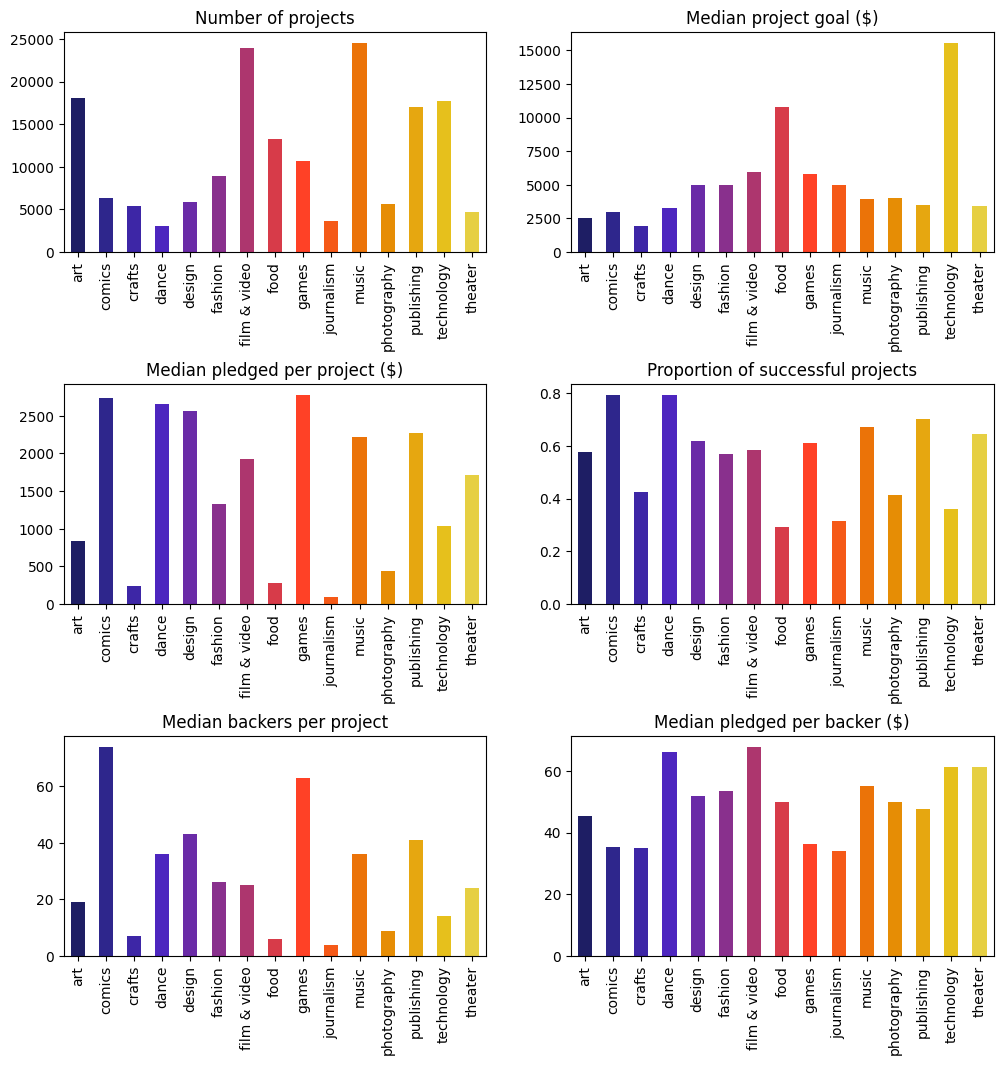

In [91]:
cat_df = pd.get_dummies(df.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique()))

df.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) 
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('category').backers_count.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

**Where do project owners come from and are some countries more successful than others?**

- The vast majority of projects are from the US, with more than six times the total number of projects compared to the second most prolific country (the UK).
- Switzerland has the highest median project goal size, although the differences in mean goal sizes are less extreme.
- Projects from Hong Kong are the most successful, have the most backers, receive more per backer, and attract considerably more money than projects from elsewhere - nearly twice the next most lucrative country (Japan).

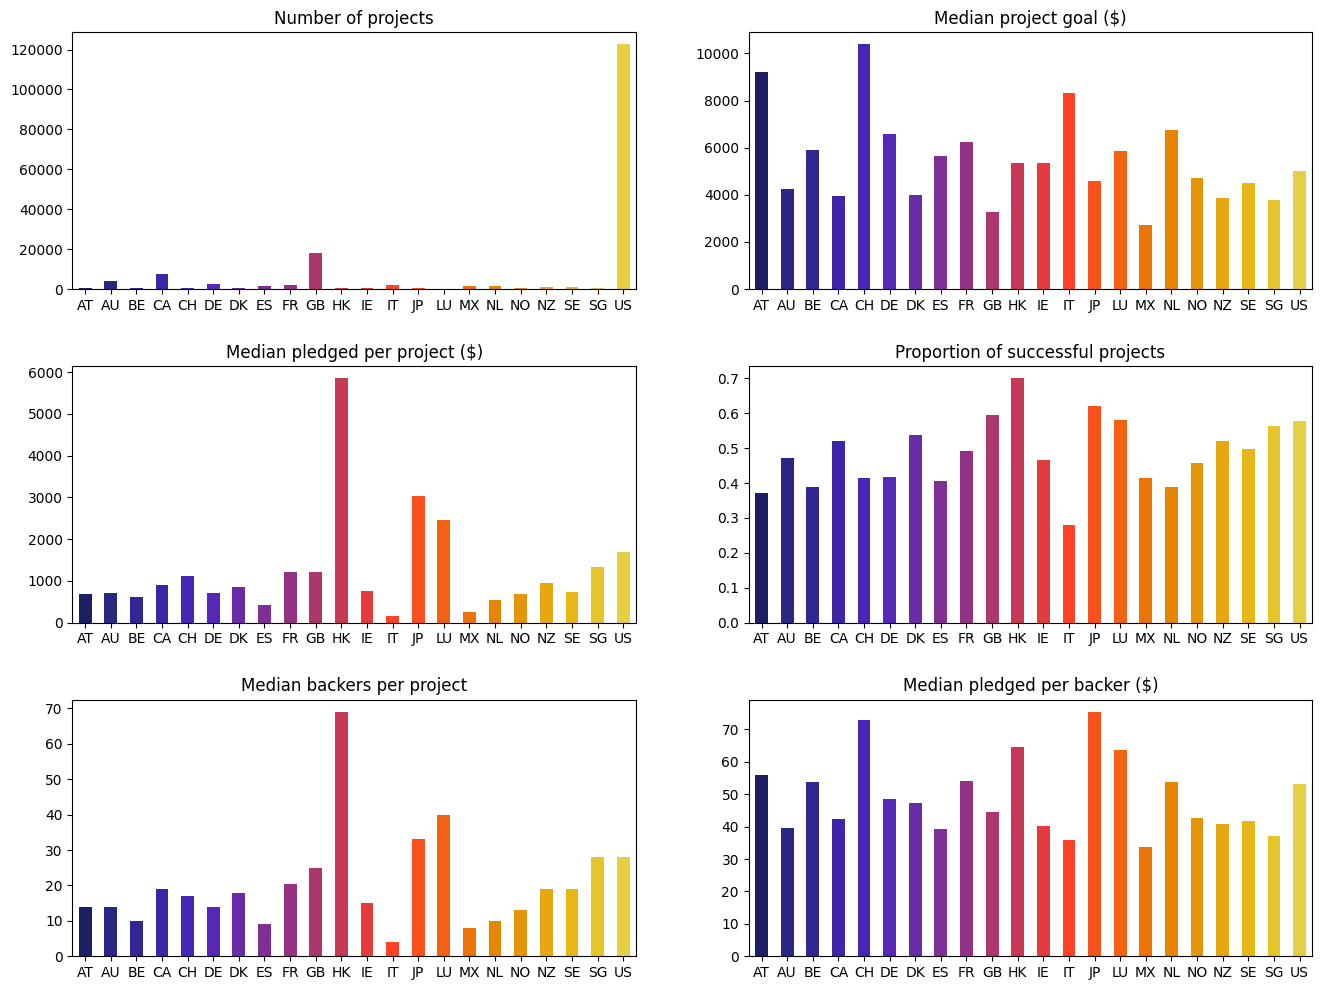

In [ ]:
country_df = pd.get_dummies(df.set_index('country').state).groupby('country').sum()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.country.nunique()))

df.groupby('country').country.count().plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('country').usd_goal.median().plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('country').usd_pledged.median().plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

country_df.div(country_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('country').backers_count.median().plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('country').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

**When is the best time to launch a project?**

- Tuesday appears to be the best day to launch a project. It is the most popular launch day, and has the highest proportion of successful projects, the most backers, the highest median amount pledged per backer, and the highest median pledge amount overall.
- Weekends (and to a lesser extent Fridays) are the least popular days to launch a project, attract less money, have fewer backers, receive smaller pledges per backer, and are slightly less successful. They also tend to have lower goals, making it more surprising that they tend to be less successful and receive less funding.

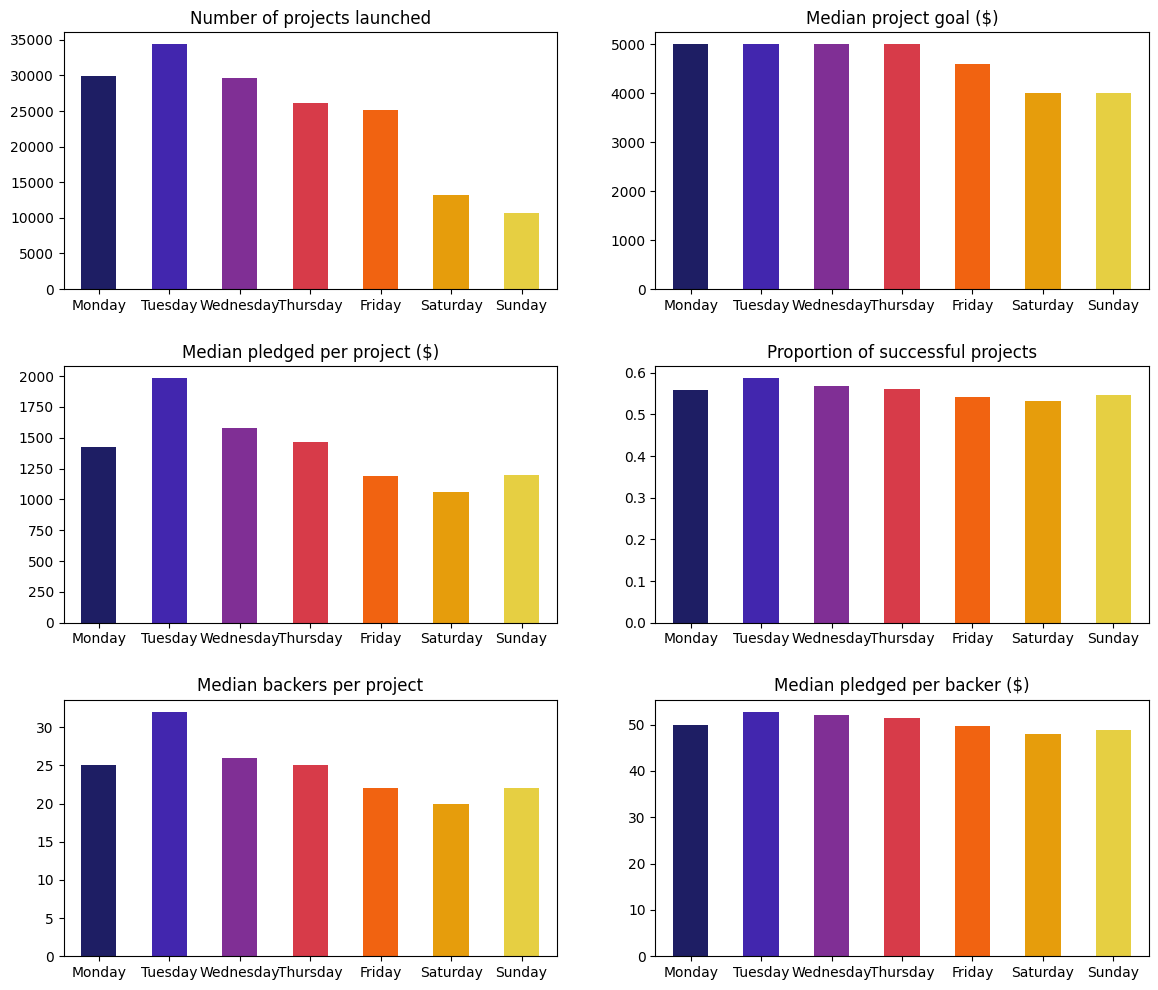

In [93]:
day_df = pd.get_dummies(df.set_index('launch_day').state).groupby('launch_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('launch_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

df.groupby('launch_day').usd_goal.median().reindex(weekdays).plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('launch_day').usd_pledged.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

day_df.div(day_df.sum(axis=1), axis=0).successful.reindex(weekdays).plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('launch_day').backers_count.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('launch_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

- The most popular month to launch a project is July, and the least common is December.
- Interestingly, both months have the lowest success rates, lowest median pledge amounts, lowest median backers per project and lowest median amount pledged per backer.
- Median goal sizes are roughly similar throughout most of the year, but smaller for projects launched in January.
- The best month to launch in is October, which has the highest median amount pledged per project, the highest success rate and the highest number of backers per project.

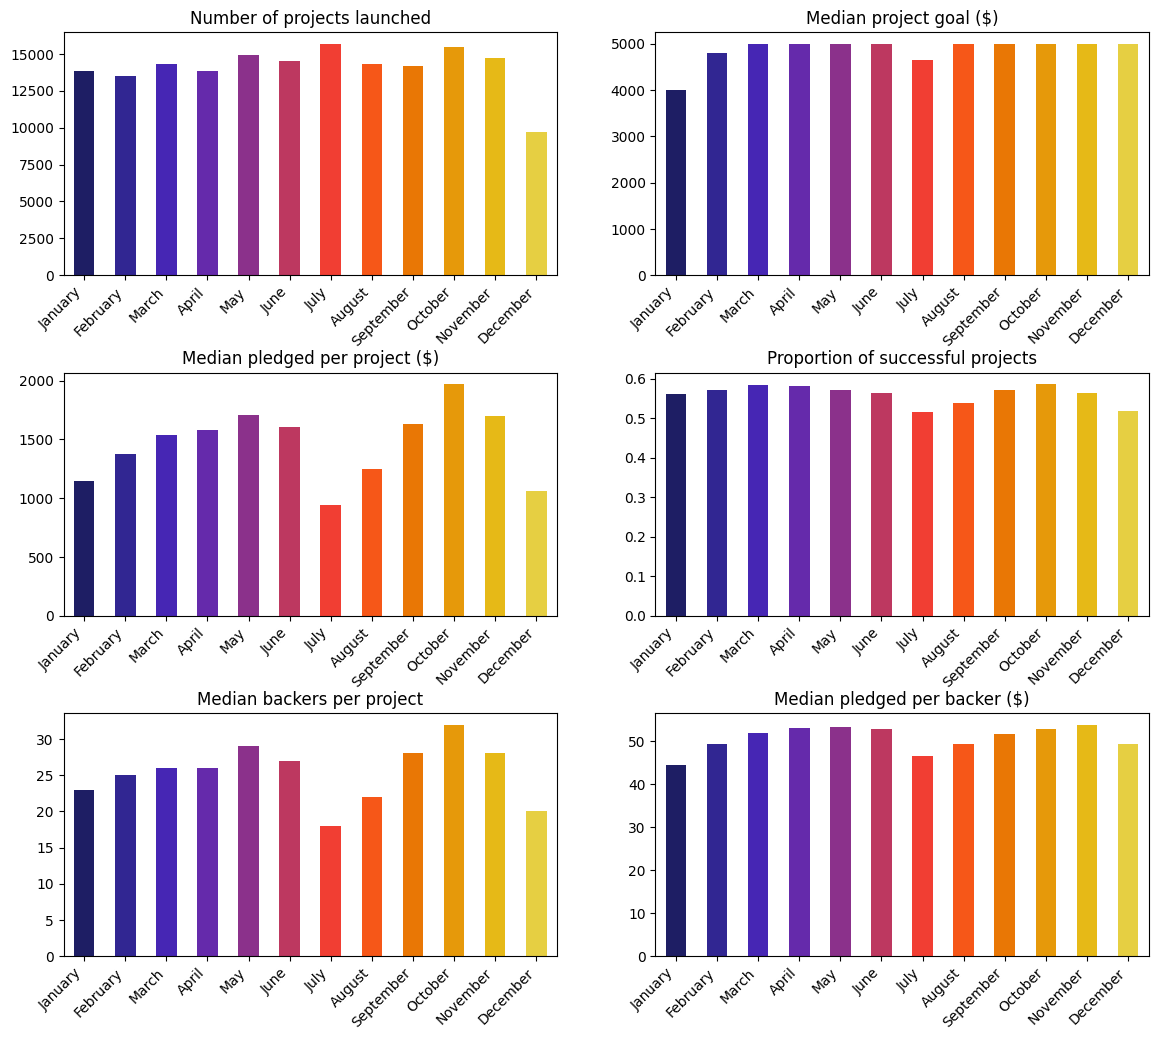

In [94]:
month_df = pd.get_dummies(df.set_index('launch_month').state).groupby('launch_month').sum()

# Plotting
months = list(calendar.month_name)[1:]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_month.nunique()))

df.groupby('launch_month').launch_month.count().reindex(months).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_goal.median().reindex(months).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_pledged.median().reindex(months).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

month_df.div(month_df.sum(axis=1), axis=0).successful.reindex(months).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_month').backers_count.median().reindex(months).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_month').pledge_per_backer.median().reindex(months).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.4)
plt.show()

- Unsurprisingly, the number of projects launched peaks during the day in the US (the times below are in UTC/GMT, so e.g. 2pm-4pm in the chart is equal to 9am-11am EST).
- More surprisingly, the median amount pledged per project and per backer does vary considerably throughout the day, with projects launched at 12pm-2pm UTC (7am-9am EST) attracting more funding and backers, on average (median), and being more likely to be successful.

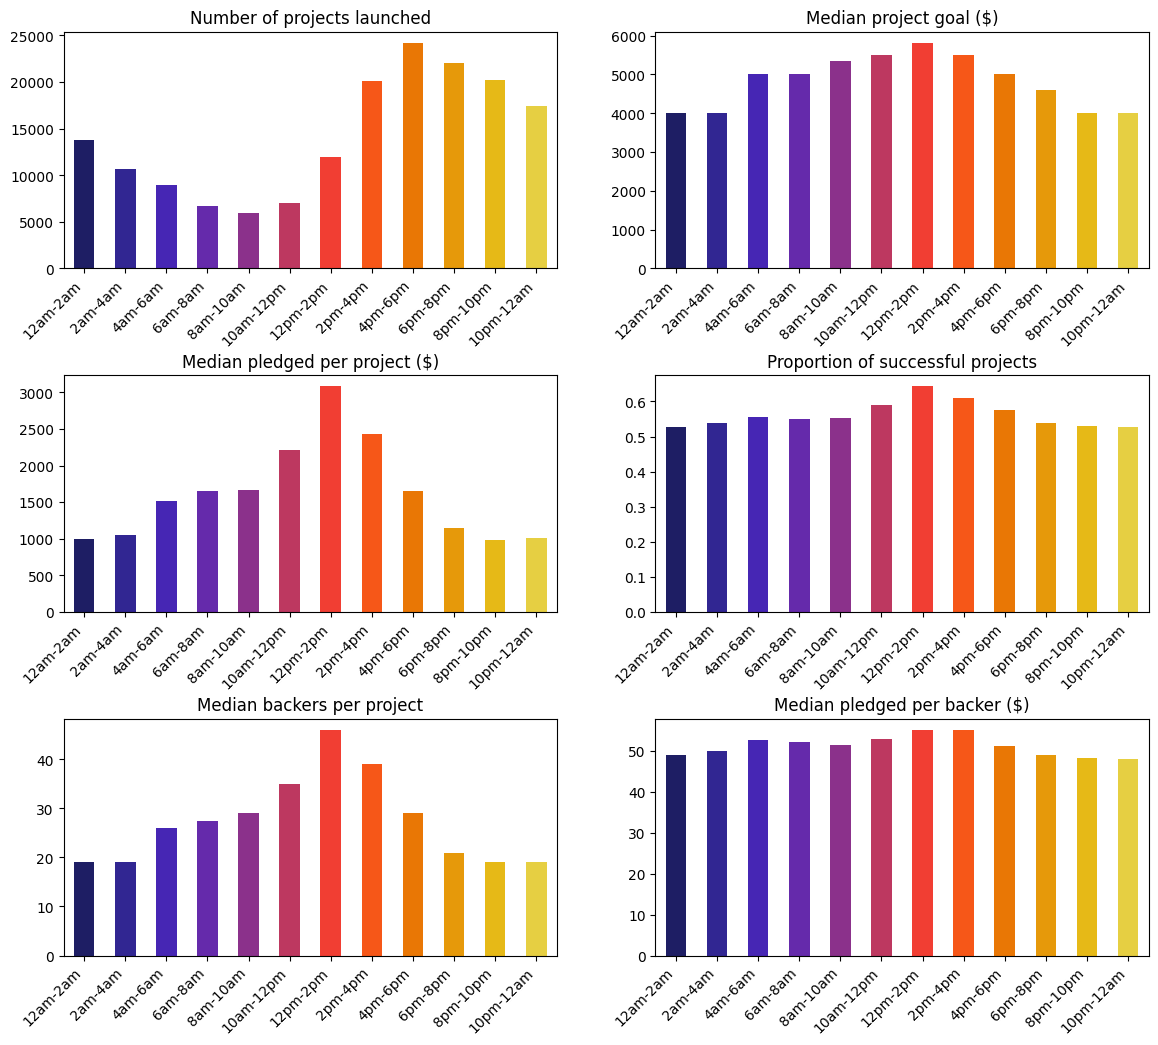

In [95]:
time_df = pd.get_dummies(df.set_index('launch_time').state).groupby('launch_time').sum()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_time.nunique()))

times = ['12am-2am', '2am-4am', '4am-6am', '6am-8am', '8am-10am', '10am-12pm', '12pm-2pm', '2pm-4pm', '4pm-6pm', '6pm-8pm', '8pm-10pm', '10pm-12am']

df.groupby('launch_time').launch_time.count().reindex(times).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_goal.median().reindex(times).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_pledged.median().reindex(times).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

time_df.div(time_df.sum(axis=1), axis=0).successful.reindex(times).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_time').backers_count.median().reindex(times).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_time').pledge_per_backer.median().reindex(times).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.45)
plt.show()

**Checking distributions**

Most continuous numerical features other than blurb_length and campaign_days are heavily positively skewed. This is not an issue for some machine learning models, so these features will not be log-transformed for the first few models. After that, models will be ru-run using log-transformed data, to see whether this improves model accuracy.

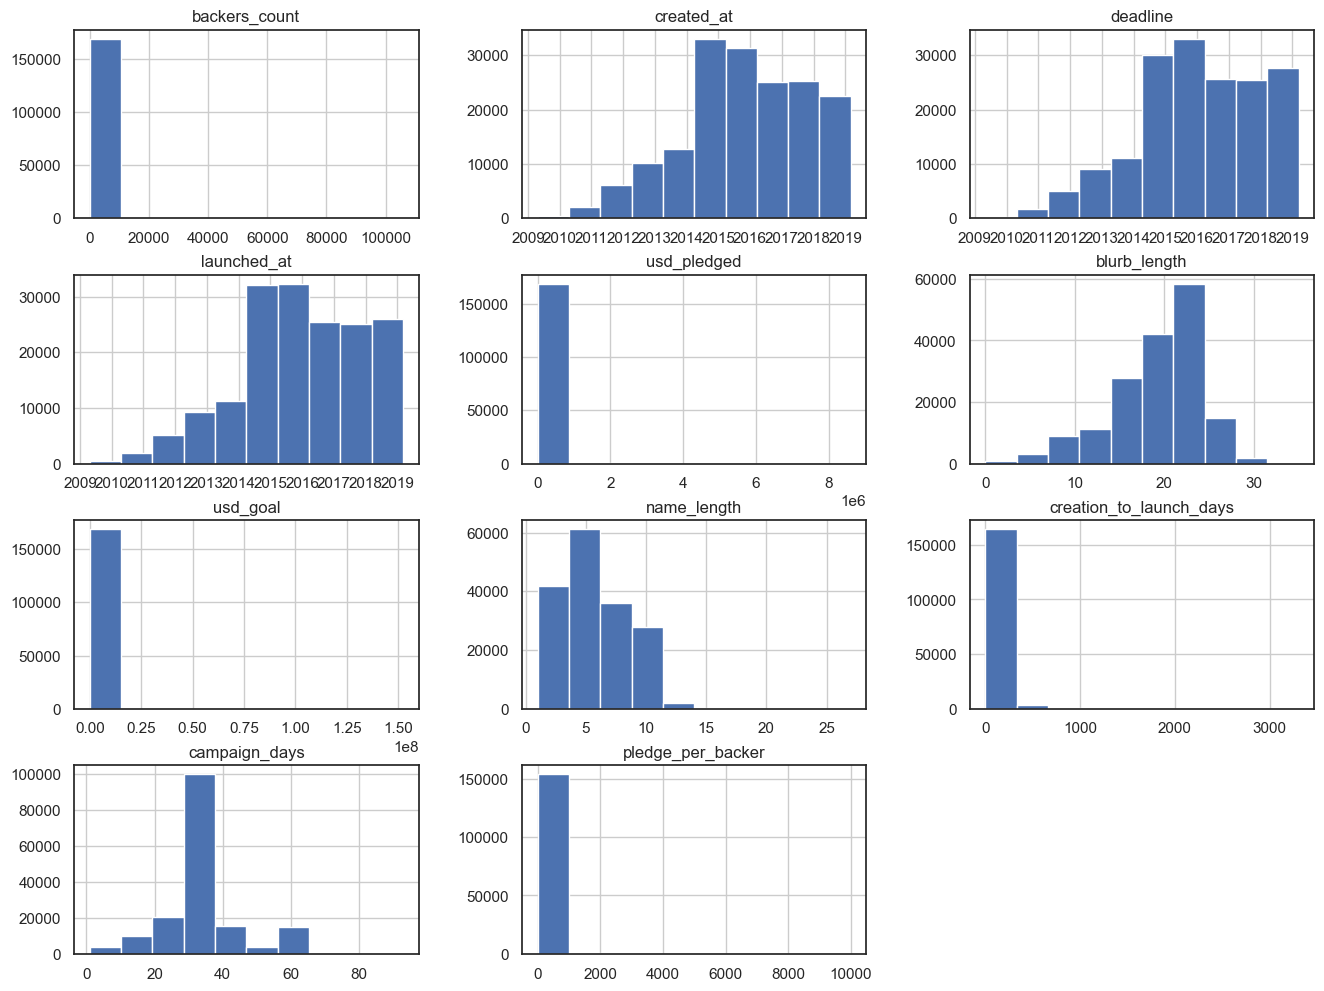

In [100]:
# Checking the distributions of continuous features
df[df.describe().columns].hist(figsize=(16,12));

**Preparing the data for machine learning**

Some features were retained for EDA purposes, but now need to be dropped in order to use machine learning models. This includes datetime features, features that are related to outcomes (e.g. the amount pledged and the number of backers) rather than related to the properties of the project itself (e.g. category, goal, length of campaign), categorical features which would result in too many one-hot encoded features (sub_category), and features that only have one category (is_starrable).

In [97]:
# Dropping columns and creating new dataframe
df_transformed = df.drop(['backers_count', 'created_at', 'deadline', 'is_starrable', 'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer'], axis=1)
df_transformed.head()

,category,country,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
id,,,,,,,,,,,,,,,
928751314,games,US,False,successful,22.0,1000.00,4,8,30,Thursday,Saturday,August,September,4pm-6pm,4pm-6pm
928014092,music,US,False,successful,15.0,15000.00,7,225,30,Monday,Wednesday,May,June,4am-6am,4am-6am
596091328,games,GB,False,failed,23.0,12160.66,8,5,60,Thursday,Monday,January,March,6pm-8pm,4pm-6pm
998516049,publishing,US,False,successful,24.0,2800.00,7,4,30,Monday,Wednesday,December,January,8pm-10pm,8pm-10pm
1224600291,music,US,False,successful,18.0,3500.00,4,159,30,Thursday,Saturday,April,May,2am-4am,2am-4am


Multi-collinearity will be checked for by assessing correlations between predictor features, as this can cause issues with some models. The multi-collinearity matrix below shows that this is not an issue:

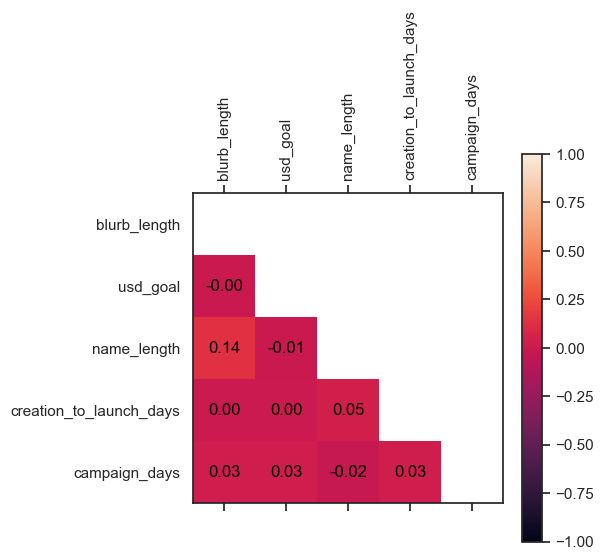

In [ ]:
sns.set(style="white")

correlation = df_transformed.select_dtypes(include='number').corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))
correlation = correlation.mask(mask)
correlation.style.background_gradient()

plt.matshow(correlation, vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(np.arange(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(np.arange(len(correlation.columns)), correlation.columns)

for i in range(len(correlation.columns)):
    for j in range(len(correlation.columns)):
        value = correlation.iloc[i, j]
        if not np.isnan(value):
            plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

plt.savefig('correlation.pdf', bbox_inches='tight')
None

The dependent variable will now be converted into 1s (successful) and 0s (failure):

In [103]:
df_transformed['state'] = df_transformed['state'].replace({'failed': 0, 'successful': 1})

Categorical features will now be one-hot encoded:

In [104]:
# Converting boolean features to string to include them in one-hot encoding
df_transformed['staff_pick'] = df_transformed['staff_pick'].astype(str)

In [105]:
# Creating dummy variables
df_transformed = pd.get_dummies(df_transformed)

Finally, the dependent (y) and independent (X) features will be separated into separate datasets. Because the features are on different scales, independent features will be transformed and normalised using StandardScaler.

In [106]:
X_unscaled = df_transformed.drop('state', axis=1)
y = df_transformed.state

In [107]:
# Transforming the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_unscaled), columns=list(X_unscaled.columns))
X.head()

,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,country_AT,country_AU,country_BE,country_CA,country_CH,...,deadline_month_September,launch_time_10am-12pm,launch_time_10pm-12am,launch_time_12am-2am,launch_time_12pm-2pm,launch_time_2am-4am,launch_time_2pm-4pm,launch_time_4am-6am,launch_time_4pm-6pm,launch_time_6am-8am,launch_time_6pm-8pm,launch_time_8am-10am,launch_time_8pm-10pm,deadline_time_10am-12pm,deadline_time_10pm-12am,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
0,0.599954,-0.036092,-0.631569,-0.303382,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,3.338081,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,2.445936,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,2.662370,-0.24725,-0.36068,-0.180051,-0.352531
1,-0.804977,-0.023491,0.476996,1.397285,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,4.239530,-0.408841,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,3.194373,-0.375605,-0.24725,-0.36068,-0.180051,-0.352531
2,0.800659,-0.026046,0.846517,-0.326894,2.325957,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,-0.408841,-0.203413,2.578810,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,2.662370,-0.24725,-0.36068,-0.180051,-0.352531
3,1.001363,-0.034472,0.476996,-0.334731,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,-0.412689,-0.186654,2.990267,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,-0.408841,-0.203413,-0.387776,-0.191523,2.714977,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,-0.375605,-0.24725,-0.36068,-0.180051,2.836630
4,-0.202864,-0.033842,-0.631569,0.880031,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,3.852439,-0.367145,-0.235875,-0.408841,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,3.148737,-0.324195,-0.313050,-0.375605,-0.24725,-0.36068,-0.180051,-0.352531


***
# Modeling

In this section, three different machine learning models for classification will be applied to the data, in order to create a model to classify projects into successes and failures.

The two categories are of a roughly equal size, so no measures need to be taken to adjust for inbalanced classes (e.g. SMOTE).

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

It is good practice to choose an evaluation method before running machine learning models - not after. The weighted average F1 score was chosen. The F1 score calculates the harmonic mean between precision and recall, and is a suitable measure because there is no preference for false positives or false negatives in this case (both are equally bad). The weighted average will be used because the classes are of slightly different sizes, and we want to be able to predict both successes and failures.

### Model 1: vanilla logistic regression

Logistic regression can be used as a binary classifier in order to predict which of two categories a data point falls in to. To create a baseline model to improve upon, a logistic regression model will be fitted to the data, with default parameters.

In [135]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [142]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

Logistic regression score for training set: 0.7099
Logistic regression score for test set: 0.71257

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.64     22312
           1       0.71      0.81      0.76     28382

    accuracy                           0.71     50694
   macro avg       0.71      0.70      0.70     50694
weighted avg       0.71      0.71      0.71     50694



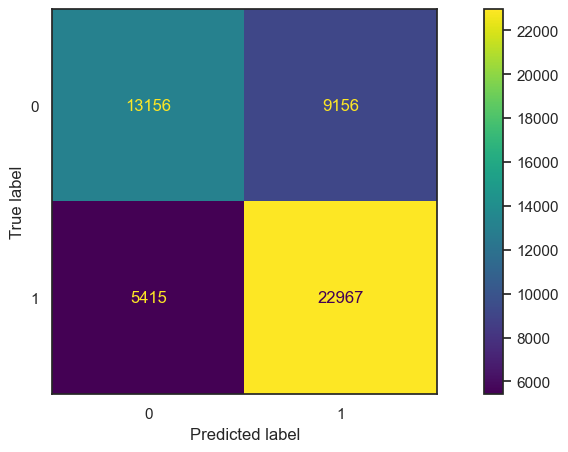

In [145]:
print("Logistic regression score for training set:", round(logreg.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_hat_test))

cm = confusion_matrix(y_test, y_hat_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()
plt.show()

AUC: 0.77945


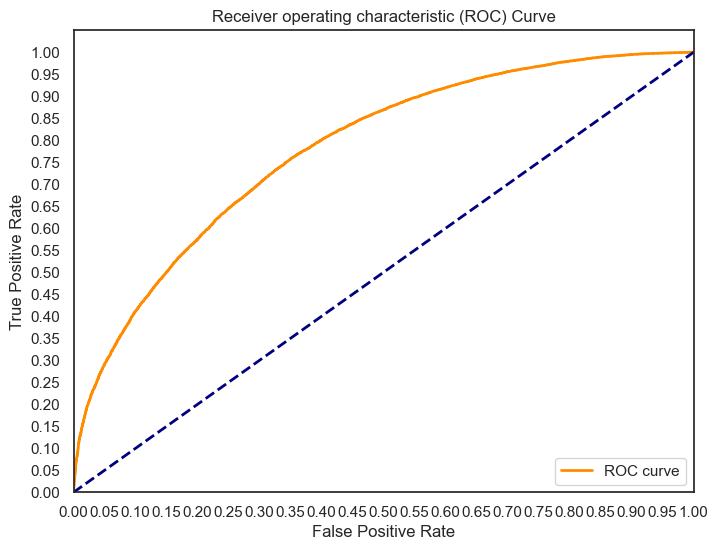

In [146]:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC:', round(auc(fpr, tpr),5))

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The logistic regression model has a fairly good accuracy score of around 0.7 (weighted average F1 score), with similar results for the test and train set. However, it is worse at predicting failures compared to successes, and the recall rate (ability to correctly predict positives out of all of the actual positives in the data) is notably different between the failure and success categories. The AUC value is pretty high, and the curve is pulled towards the top left of the graph, which is a positive sign. However, this can probably be improved upon.

### Principal Component Analysis and feature weightings

There are a large number of features in the dataset (106). PCA (Principal Component Analysis) can be used to reduce this into a smaller number of components which still explain as much variation in the data as possible.

In [147]:
pca = PCA()
pca.fit_transform(X)
explained_var = np.cumsum(pca.explained_variance_ratio_)

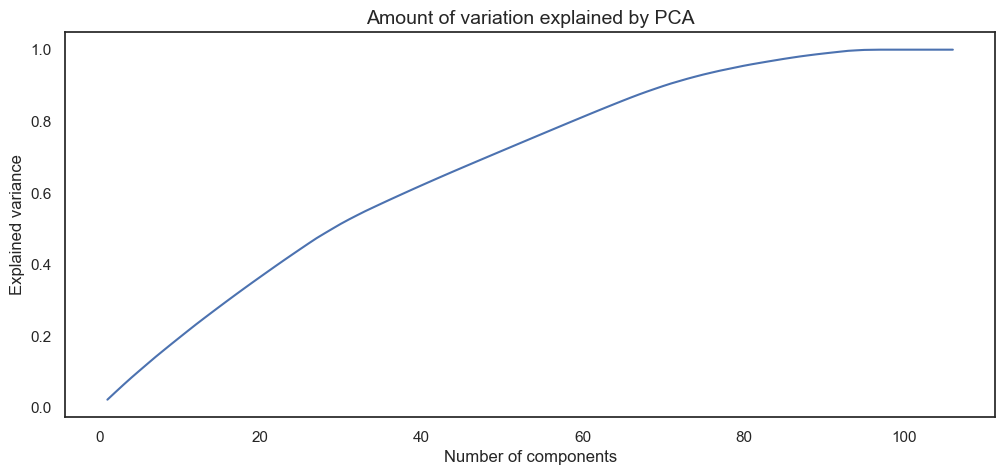

In [148]:
plt.plot(list(range(1, len(explained_var)+1)), explained_var)
plt.title('Amount of variation explained by PCA', fontsize=14)
plt.xlabel('Number of components')
plt.ylabel('Explained variance');

There is no obvious elbow in this plot, so three different values for n_components will be tried below with logistic regression to see which produces the best score.

In [149]:
print("Number of components explaining 80% of variance:", np.where(explained_var > 0.8)[0][0])
print("Number of components explaining 90% of variance:", np.where(explained_var > 0.9)[0][0])
print("Number of components explaining 99% of variance:", np.where(explained_var > 0.99)[0][0])

Number of components explaining 80% of variance: 58
Number of components explaining 90% of variance: 70
Number of components explaining 99% of variance: 90


The number of components to be used will be assessed by running logistic regression models using each of the three numbers of components.

In [150]:
n_comps = [58,70,90]
for n in n_comps:
    pipe = Pipeline([('pca', PCA(n_components=n)), ('clf', LogisticRegression())])
    pipe.fit(X_train, y_train)
    print("\nNumber of components:", n)
    print("Score:", round(pipe.score(X_test, y_test),5))


Number of components: 58
Score: 0.68483

Number of components: 70
Score: 0.68815

Number of components: 90
Score: 0.71158


The above results show that the score is highest for 90 components, although the difference is small (c. 3% improvement from 58 components).

In [151]:
# Feature weightings on each component, in order of average weighting
pca = PCA(n_components=90)
pca.fit_transform(X)
pca_90_components = pd.DataFrame(pca.components_,columns=X.columns).T # Components as columns, features as rows
pca_90_components['mean_weight'] = pca_90_components.iloc[:].abs().mean(axis=1)
pca_90_components.sort_values('mean_weight', ascending=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,mean_weight
country_AU,-0.093392,0.067953,0.001362,0.019028,0.034640,-0.093699,-0.031610,-0.023843,0.027671,0.012091,-0.030459,-0.016795,-0.001161,-0.004514,-0.025804,-0.003087,-0.013749,-0.038115,-0.013794,0.000238,-0.041995,0.045363,0.012439,-0.038881,0.018219,...,-0.016653,0.074456,0.056750,-0.041832,0.033356,-0.021590,-0.015145,-0.003536,0.005422,-0.006426,-0.002975,0.010442,-0.007748,0.002464,-0.022499,-0.012899,0.001471,-0.002842,-0.005264,0.003591,-0.001571,-0.017385,0.012334,0.004528,0.062261
country_CA,-0.073302,0.041366,-0.004677,0.018850,-0.017889,-0.001621,0.014536,-0.027416,0.002842,-0.003082,0.005771,0.021097,-0.001050,0.016576,0.019308,0.009964,0.007381,0.020278,-0.000592,-0.010593,0.015138,0.010551,-0.000584,0.012026,0.007790,...,-0.170048,-0.064581,-0.010981,0.048832,0.001431,0.009853,0.021513,-0.000766,0.008265,-0.006631,-0.005325,0.008360,-0.005141,0.007533,0.007816,0.022724,0.001871,0.006599,0.006964,0.018600,0.005578,0.015653,0.009684,0.001682,0.061676
launch_time_2am-4am,0.165675,-0.019674,0.036022,-0.017465,0.095861,-0.133347,-0.018980,-0.037339,-0.028938,0.047173,-0.082916,-0.011565,-0.111735,-0.045185,0.004062,-0.094810,-0.045401,-0.156759,0.176010,-0.010542,-0.047918,0.076784,0.256606,0.114596,-0.302646,...,0.032544,0.004162,-0.009639,-0.011280,-0.011023,-0.013371,0.051251,-0.003938,-0.007051,-0.330990,-0.101991,-0.315646,0.057830,-0.318617,0.043259,0.206644,0.057401,0.073918,0.152959,0.136198,0.128655,0.125097,-0.126996,-0.010083,0.061618
country_MX,-0.018262,0.030079,0.008870,-0.005785,-0.001752,0.008582,-0.008846,-0.001412,0.012444,0.014609,-0.009135,-0.000143,-0.008511,-0.020450,0.004060,0.012652,0.004323,0.017519,-0.004599,-0.007251,0.015878,-0.004278,-0.011433,0.003157,0.007901,...,-0.260567,-0.069938,-0.034415,0.060466,-0.025985,0.005914,0.007923,0.009473,-0.002463,0.016643,0.008028,0.004675,0.007918,0.006977,-0.003330,0.009853,0.001968,0.004478,0.005141,0.008784,0.001668,0.002539,0.007093,-0.002299,0.061149
deadline_time_2am-4am,0.174719,-0.073606,0.025139,-0.029994,0.096424,-0.138304,-0.015486,-0.019002,-0.027514,0.038080,-0.085175,-0.022451,-0.104822,-0.057136,0.004981,-0.094809,-0.043636,-0.152930,0.174424,-0.006801,-0.043337,0.077807,0.252461,0.130570,-0.317270,...,0.008548,-0.014489,-0.012154,-0.026879,0.016820,0.011573,-0.034888,0.003051,0.015725,0.319804,0.092158,0.303013,-0.058472,0.315422,-0.041601,-0.204777,-0.058960,-0.073609,-0.152046,-0.136480,-0.120643,-0.116729,0.117861,0.004629,0.060733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
launch_day_Wednesday,0.003610,-0.013427,-0.007476,0.006800,0.009437,0.011076,-0.006760,-0.015839,-0.004375,0.020600,0.033591,-0.038216,0.000129,0.010414,0.027340,0.000047,-0.250799,0.123787,-0.046165,-0.187586,0.150000,-0.027965,0.470478,-0.057100,0.207090,...,-0.022321,0.093011,0.039822,0.316255,-0.022631,-0.311695,-0.419759,-0.140698,-0.016576,0.004686,0.002565,-0.009296,0.008832,-0.005916,-0.002419,0.004938,0.005912,-0.003303,0.011117,0.006159,0.001184,0.003545,-0.001789,0.007466,0.040278
staff_pick_True,-0.081522,-0.293798,0.282847,-0.286816,-0.079206,0.023048,-0.223276,0.250695,0.064197,0.077858,-0.032824,-0.156196,0.018755,-0.114891,-0.078568,0.036093,-0.047557,0.124583,-0.028471,-0.039299,0.070915,-0.018416,-0.075515,0.040256,-0.040799,...,0.006903,-0.001149,0.006012,0.001538,-0.045381,0.004575,0.008634,-0.005505,-0.006378,-0.003385,-0.002453,-0.003980,0.000039,-0.004106,0.004258,0.006270,0.002074,0.001889,0.003534,0.001609,0.003647,0.007736,-0.012441,-0.001486,0.040121
staff_pick_False,0.081522,0.293798,-0.282847,0.286816,0.079206,-0.023048,0.223276,-0.250695,-0.064197,-0.077858,0.032824,0.156196,-0.018755,0.114891,0.078568,-0.036093,0.047557,-

The graph below plots the average weight of each feature on each component. It shows that there is relatively little variation between the average weights of each feature, i.e. how much each feature is included in each component.

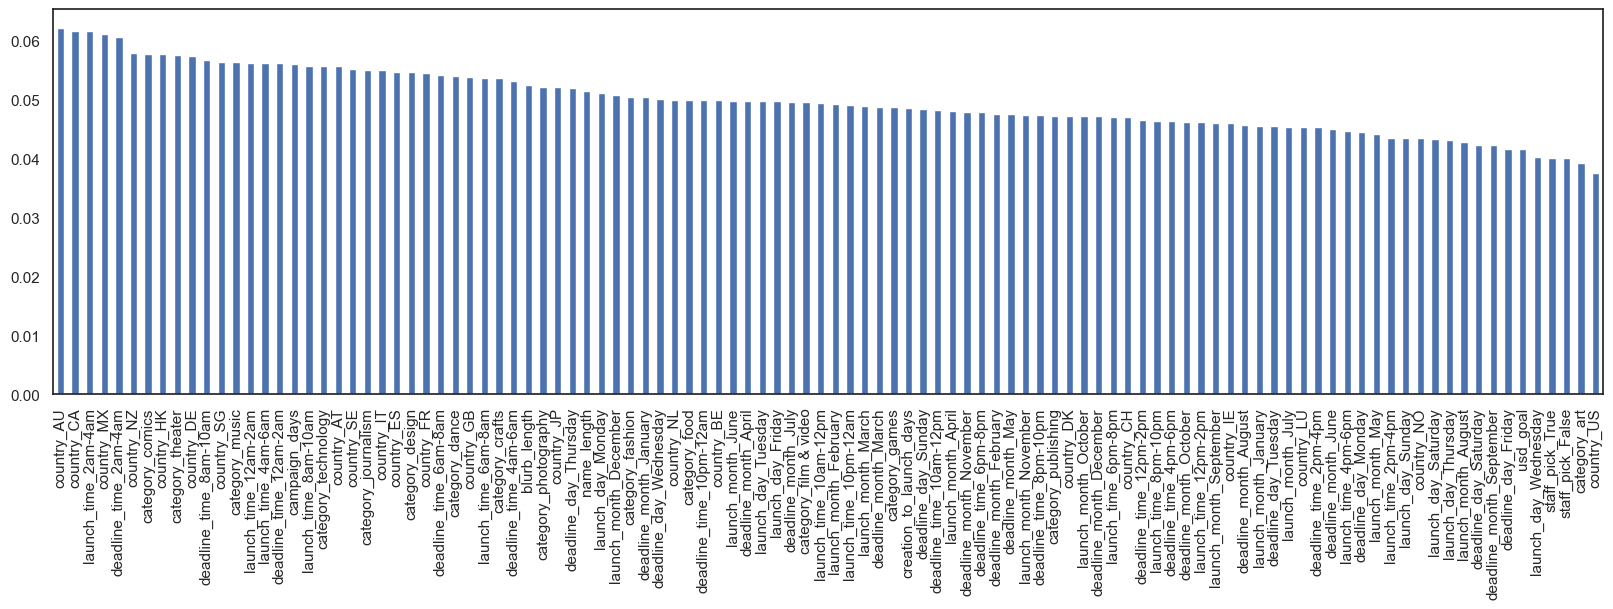

In [152]:
# Plotting feature importances
plt.figure(figsize=(20,5))
pca_90_components.mean_weight.sort_values(ascending=False).plot(kind='bar')
plt.show()

The tables below show the top 10 most important features in the top three most important components.

- Component 1 - the top two features relate to the country a project is from, primarily the US and the UK (the top two most common countries).
- Component 2 - the top two features relate to whether or not a project was highlighted as a staff pick.
- Component 3 - the top two features relate to the timings of the project, specifically whether it was launched in October or had a deadline in November.

In [153]:
pca_90_components[0].map(lambda x : x).abs().sort_values(ascending = False)[:10]

country_US                 0.463781
country_GB                 0.308806
deadline_time_10am-12pm    0.272187
launch_time_10am-12pm      0.266231
launch_time_8am-10am       0.238375
deadline_time_8am-10am     0.228762
deadline_time_2am-4am      0.174719
launch_time_12am-2am       0.171094
deadline_time_12pm-2pm     0.166497
launch_time_2am-4am        0.165675
Name: 0, dtype: float64

In [154]:
pca_90_components[1].map(lambda x : x).abs().sort_values(ascending = False)[:10]

staff_pick_False           0.293798
staff_pick_True            0.293798
launch_time_2pm-4pm        0.229406
launch_month_January       0.222982
deadline_month_February    0.213230
deadline_time_2pm-4pm      0.210429
launch_month_December      0.204880
deadline_month_January     0.204583
deadline_month_March       0.172262
country_US                 0.170866
Name: 1, dtype: float64

In [155]:
pca_90_components[2].map(lambda x : x).abs().sort_values(ascending = False)[:10]

launch_month_October       0.302886
deadline_month_November    0.293325
staff_pick_False           0.282847
staff_pick_True            0.282847
deadline_month_December    0.276394
launch_month_November      0.268912
deadline_month_July        0.204546
launch_month_June          0.200529
launch_month_May           0.187311
deadline_month_June        0.183052
Name: 2, dtype: float64

### Model 2: logistic regression with PCA and parameter optimisation

The logistic regression model can potentially be further improved by optimising its parameters. GridSearchCV can be used to test multiple different regularisation parameters (values of C), penalties (l1 or l2) and models with and without an intercept.

In [156]:
logreg_start = time.time()

pipe_logreg = Pipeline([('pca', PCA(n_components=90)),
                    ('clf', LogisticRegression())])

params_logreg = [
    {'clf__penalty': ['l1', 'l2'],
     'clf__fit_intercept': [True, False],
        'clf__C': [0.001, 0.01, 1, 10]
    }
]

grid_logreg = GridSearchCV(estimator=pipe_logreg,
                  param_grid=params_logreg,
                  cv=5)

grid_logreg.fit(X_train, y_train)

logreg_end = time.time()

logreg_best_score = grid_logreg.best_score_
logreg_best_params = grid_logreg.best_params_

print(f"Time taken to run: {round((logreg_end - logreg_start)/60,1)} minutes")
print("Best accuracy:", round(logreg_best_score,2))
print("Best parameters:", logreg_best_params)

Time taken to run: 0.5 minutes
Best accuracy: 0.71
Best parameters: {'clf__C': 10, 'clf__fit_intercept': True, 'clf__penalty': 'l2'}


**Best logistic regression model**

Logistic regression score for training set: 0.71008
Logistic regression score for test set: 0.71247

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.64     22312
           1       0.71      0.81      0.76     28382

    accuracy                           0.71     50694
   macro avg       0.71      0.70      0.70     50694
weighted avg       0.71      0.71      0.71     50694



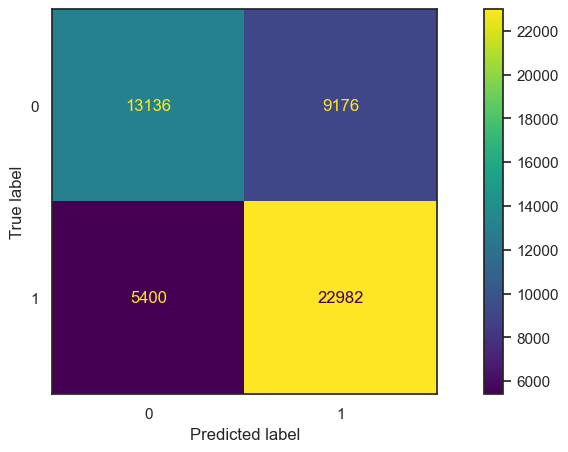

In [157]:
pipe_best_logreg = Pipeline([('pca', PCA(n_components=90)),
                    ('clf', LogisticRegression(C=10, fit_intercept=True, penalty='l2'))])

pipe_best_logreg.fit(X_train, y_train)

lr_y_hat_train = pipe_best_logreg.predict(X_train)
lr_y_hat_test = pipe_best_logreg.predict(X_test)

print("Logistic regression score for training set:", round(pipe_best_logreg.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(pipe_best_logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test))

cm = confusion_matrix(y_test, lr_y_hat_test, labels=pipe_best_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_best_logreg.classes_)
disp.plot()
plt.show()

After hyperparameter tuning, the model's accuracy score is the same as the logistic regression model using default parameters (0.70 weighted average F1 score).

### Model 3: Random Forests

The Random Forest algorithm is a supervised learning algorithm that can be used for classification. It works by building multiple different decision trees to predict which category a data point belongs to.

In [158]:
pipe_rf = Pipeline([('pca', PCA(n_components=10)),
                    ('clf', RandomForestClassifier())])
pipe_rf.fit(X_train, y_train)
print("Score:", round(pipe_rf.score(X_test, y_test),5))

Score: 0.62648


In [159]:
# Reporting the depths of each tree in the model created by the default Random Forest classifier, to get a sense of the
# maximum depth that a tree can be if depth is not limited, to help with choosing parameters to try with GridSearchCV
[estimator.tree_.max_depth for estimator in pipe_rf.named_steps['clf'].estimators_]

[57,
 51,
 58,
 53,
 49,
 49,
 48,
 51,
 53,
 49,
 49,
 48,
 49,
 46,
 43,
 52,
 49,
 47,
 51,
 51,
 49,
 51,
 46,
 54,
 49,
 47,
 45,
 47,
 51,
 60,
 54,
 55,
 49,
 66,
 53,
 48,
 51,
 47,
 50,
 48,
 49,
 52,
 53,
 52,
 51,
 55,
 55,
 51,
 52,
 52,
 49,
 52,
 51,
 50,
 49,
 46,
 52,
 51,
 54,
 48,
 53,
 51,
 49,
 59,
 52,
 46,
 69,
 46,
 55,
 56,
 53,
 48,
 53,
 46,
 50,
 50,
 56,
 54,
 47,
 46,
 51,
 49,
 52,
 48,
 47,
 52,
 47,
 51,
 44,
 58,
 45,
 53,
 47,
 49,
 48,
 60,
 53,
 55,
 46,
 53]

In [132]:
rf_start = time.time()

pipe_rf = Pipeline([('pca', PCA(n_components=5)),
                    ('clf', RandomForestClassifier())])

params_rf = [ 
  {'clf__n_estimators': [100],    
   'clf__min_samples_split':[0.001, 0.01]
  }
]

grid_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid=params_rf,
                  cv=3)

grid_rf.fit(X_train, y_train)

rf_end = time.time()

rf_best_score = grid_rf.best_score_
rf_best_params = grid_rf.best_params_

print(f"Time taken to run: {round((rf_end - rf_start)/60,1)} minutes")
print("Best accuracy:", round(rf_best_score,2))
print("Best parameters:", rf_best_params)

Time taken to run: 4.7 minutes
Best accuracy: 0.61
Best parameters: {'clf__min_samples_split': 0.001, 'clf__n_estimators': 100}


**Best Random Forest model**

Random Forest score for training set: 0.74374
Random Forest score for test set: 0.61514

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.51      0.54     22312
           1       0.64      0.70      0.67     28382

    accuracy                           0.62     50694
   macro avg       0.61      0.60      0.60     50694
weighted avg       0.61      0.62      0.61     50694



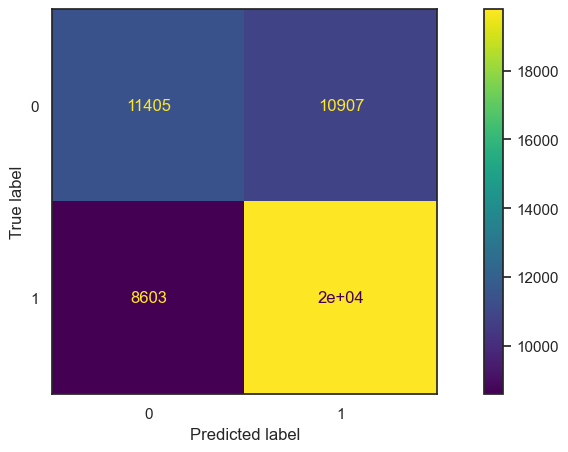

In [161]:
pipe_best_rf = Pipeline([('pca', PCA(n_components=5)),
                    ('clf', RandomForestClassifier(min_samples_split=0.001, n_estimators=100))])

pipe_best_rf.fit(X_train, y_train)

rf_y_hat_train = pipe_best_rf.predict(X_train)
rf_y_hat_test = pipe_best_rf.predict(X_test)

print("Random Forest score for training set:", round(pipe_best_rf.score(X_train, y_train),5))
print("Random Forest score for test set:", round(pipe_best_rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, rf_y_hat_test))

cm = confusion_matrix(y_test, rf_y_hat_test, labels=pipe_best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_best_rf.classes_)
disp.plot()
plt.show()

After hyperparameter tuning, the model's accuracy score has increased from 0.65 to 0.69 (weighted average f1 score). However, the difference between the accuracy score for the training set and the test set suggests there might be some over-fitting.

### Model 4: XGBoost

XGBoost is a form of gradient boosting algorithm. Similar to Random Forests, it is an ensemble method that produces multiple decision trees to improve classification of data points, but it uses gradient descent to improve the performance of the model for the data points that are particularly difficult to classify.

In [162]:
pipe_xgb = Pipeline([('pca', PCA(n_components=5)),
                    ('clf', xgb.XGBClassifier())])
pipe_xgb.fit(X_train, y_train)
print("Score:", round(pipe_xgb.score(X_test, y_test),5))

Score: 0.60662


In [163]:
xgb_start = time.time()

pipe_xgb = Pipeline([('pca', PCA(n_components=5)),
                    ('clf', xgb.XGBClassifier())])

params_xgb = [ 
  {'clf__n_estimators': [100],
   'clf__learning_rate': [0.01, 0.1],
   'clf__subsample': [0.7, 1],
   'clf__min_child_weight': [20, 100]
  }
]

grid_xgb = GridSearchCV(estimator=pipe_xgb,
                  param_grid=params_xgb,
                  cv=3)

grid_xgb.fit(X_train, y_train)

xgb_end = time.time()

xgb_best_score = grid_xgb.best_score_
xgb_best_params = grid_xgb.best_params_

print(f"Time taken to run: {round((xgb_end - xgb_start)/60,1)} minutes")
print("Best accuracy:", round(xgb_best_score,2))
print("Best parameters:", xgb_best_params)

Time taken to run: 0.2 minutes
Best accuracy: 0.61
Best parameters: {'clf__learning_rate': 0.1, 'clf__min_child_weight': 20, 'clf__n_estimators': 100, 'clf__subsample': 0.7}


**Best XGBoost model**

XGBoost score for training set: 0.62168
XGBoost score for test set: 0.60786

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.49      0.52     22312
           1       0.64      0.70      0.67     28382

    accuracy                           0.61     50694
   macro avg       0.60      0.60      0.60     50694
weighted avg       0.60      0.61      0.60     50694



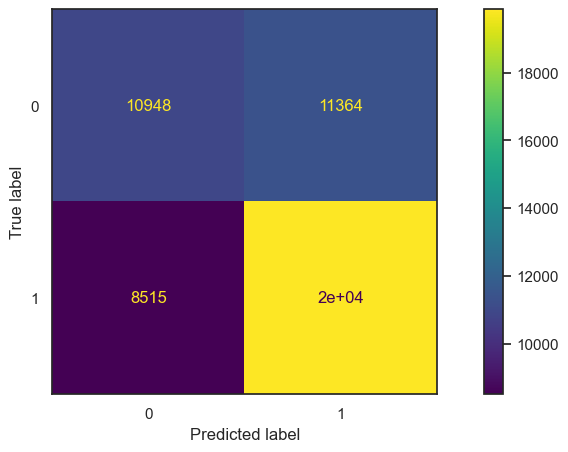

In [164]:
pipe_best_xgb = Pipeline([('pca', PCA(n_components=5)),
                    ('clf', xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=100, n_estimators=100, subsample=0.7))])

pipe_best_xgb.fit(X_train, y_train)

xgb_y_hat_train = pipe_best_xgb.predict(X_train)
xgb_y_hat_test = pipe_best_xgb.predict(X_test)

print("XGBoost score for training set:", round(pipe_best_xgb.score(X_train, y_train),5))
print("XGBoost score for test set:", round(pipe_best_xgb.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, xgb_y_hat_test))

cm = confusion_matrix(y_test, xgb_y_hat_test, labels=pipe_best_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_best_xgb.classes_)
disp.plot()
plt.show()

After hyperparameter tuning, the model's accuracy has increased from 0.69 to 0.7, although this is a very small increase for a very computationally-expensive hyperparameter tuning process. There also appears to be some over-fitting, from the difference in train and test scores.

### Model 5: vanilla logistic regression with log-transformed data

Previously, positively skewed data was not log-transformed. Now a log transformation will be applied to the skewed features, and a logistic regression model fitted again to see whether this improved accuracy.

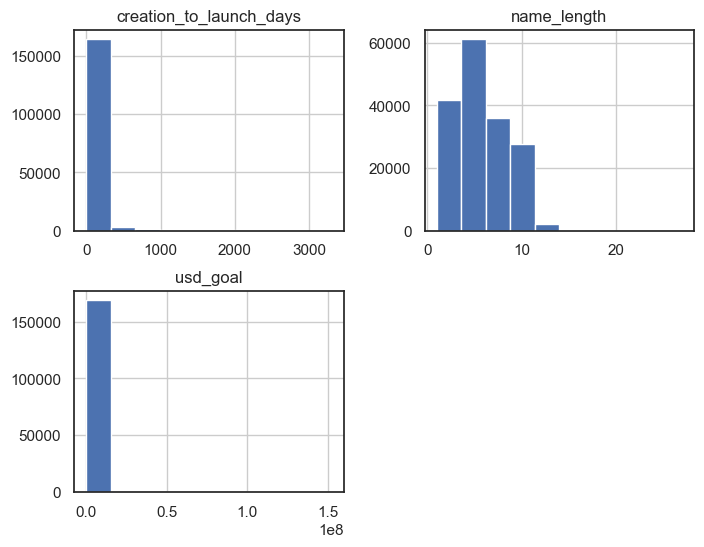

In [165]:
cols_to_log = ['creation_to_launch_days', 'name_length', 'usd_goal']
df_transformed[cols_to_log].hist(figsize=(8,6));

In [166]:
for col in cols_to_log:
    df_transformed[col] = df_transformed[col].astype('float64').replace(0.0, 0.01)
    df_transformed[col] = np.log(df_transformed[col])

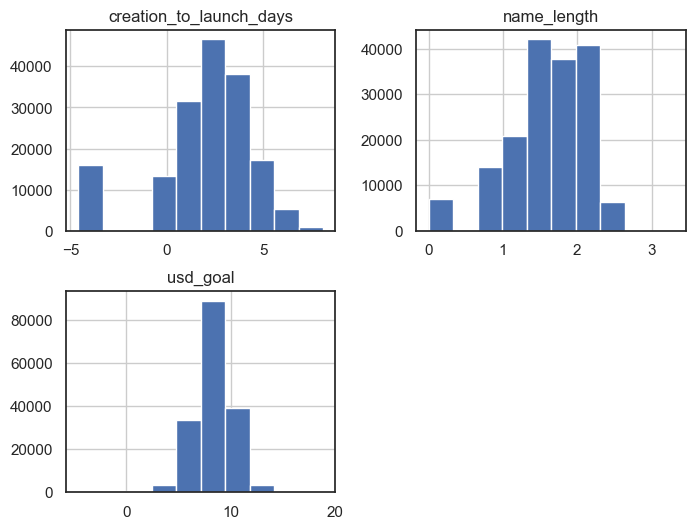

In [167]:
df_transformed[cols_to_log].hist(figsize=(8,6));

In [168]:
df_transformed.head()

,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,country_AT,country_AU,country_BE,country_CA,...,deadline_month_September,launch_time_10am-12pm,launch_time_10pm-12am,launch_time_12am-2am,launch_time_12pm-2pm,launch_time_2am-4am,launch_time_2pm-4pm,launch_time_4am-6am,launch_time_4pm-6pm,launch_time_6am-8am,launch_time_6pm-8pm,launch_time_8am-10am,launch_time_8pm-10pm,deadline_time_10am-12pm,deadline_time_10pm-12am,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
928751314,1,22.0,6.907755,1.386294,2.079442,30,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
928014092,1,15.0,9.615805,1.945910,5.416100,30,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
596091328,0,23.0,9.405961,2.079442,1.609438,60,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
998516049,1,24.0,7.937375,1.945910,1.386294,30,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1224600291,1,18.0,8.160518,1.386294,5.068904,30,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


Now the data can be prepared again for machine learning by separating X and y, and scaling:

In [169]:
X_unscaled_log = df_transformed.drop('state', axis=1)
y_log = df_transformed.state

In [170]:
scaler = StandardScaler()
X_log = pd.DataFrame(scaler.fit_transform(X_unscaled_log), columns=list(X_unscaled_log.columns))
X_log.head()

,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,country_AT,country_AU,country_BE,country_CA,country_CH,...,deadline_month_September,launch_time_10am-12pm,launch_time_10pm-12am,launch_time_12am-2am,launch_time_12pm-2pm,launch_time_2am-4am,launch_time_2pm-4pm,launch_time_4am-6am,launch_time_4pm-6pm,launch_time_6am-8am,launch_time_6pm-8pm,launch_time_8am-10am,launch_time_8pm-10pm,deadline_time_10am-12pm,deadline_time_10pm-12am,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
0,0.599954,-0.863064,-0.369130,0.046185,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,3.338081,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,2.445936,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,2.662370,-0.24725,-0.36068,-0.180051,-0.352531
1,-0.804977,0.694414,0.596395,1.329281,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,4.239530,-0.408841,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,3.194373,-0.375605,-0.24725,-0.36068,-0.180051,-0.352531
2,0.800659,0.573727,0.826781,-0.134553,2.325957,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,-0.408841,-0.203413,2.578810,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,2.662370,-0.24725,-0.36068,-0.180051,-0.352531
3,1.001363,-0.270900,0.596395,-0.220362,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,-0.412689,-0.186654,2.990267,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,-0.408841,-0.203413,-0.387776,-0.191523,2.714977,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,-0.375605,-0.24725,-0.36068,-0.180051,2.836630
4,-0.202864,-0.142564,-0.369130,1.195768,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,3.852439,-0.367145,-0.235875,-0.408841,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,3.148737,-0.324195,-0.313050,-0.375605,-0.24725,-0.36068,-0.180051,-0.352531


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3, random_state=123)

Logistic regression score for training set: 0.73373
Logistic regression score for test set: 0.73407

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68     22312
           1       0.74      0.80      0.77     28382

    accuracy                           0.73     50694
   macro avg       0.73      0.72      0.73     50694
weighted avg       0.73      0.73      0.73     50694



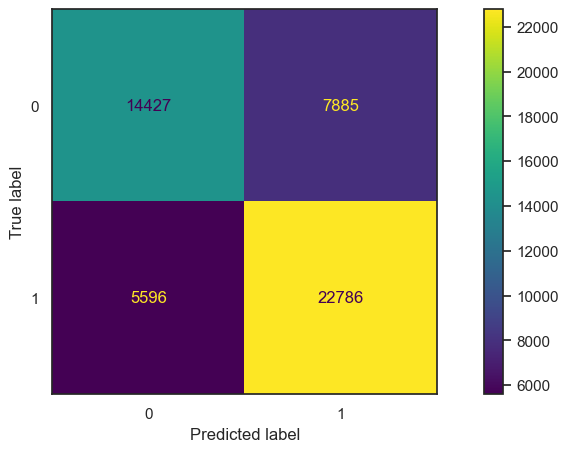

In [172]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

lr_y_hat_train2 = logreg.predict(X_train)
lr_y_hat_test2 = logreg.predict(X_test)

print("Logistic regression score for training set:", round(logreg.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(logreg.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test2))

cm = confusion_matrix(y_test, lr_y_hat_test2, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()
plt.show()

Log-transforming the data has increased the accuracy by 0.03 to 0.73.

### Model 6: Random Forests without PCA

A Random Forest model will now be fitted using the log-transformed data, but without using PCA. This is to allow for the construction of a list of feature importances.

In [173]:
rf_start2 = time.time()

rf2 = RandomForestClassifier(min_samples_split=0.001)

params_rf2 = [ 
  {'n_estimators': [200, 400],
   'max_depth': [5,10]
  }
]

grid_rf2 = GridSearchCV(estimator=rf2, param_grid=params_rf2, cv=5)

grid_rf2.fit(X_train, y_train)

rf_end2 = time.time()

rf_best_score2 = grid_rf2.best_score_
rf_best_params2 = grid_rf2.best_params_

print(f"Time taken to run: {round((rf_end2 - rf_start2)/60,1)} minutes")
print("Best accuracy:", round(rf_best_score2,2))
print("Best parameters:", rf_best_params2)

Time taken to run: 7.9 minutes
Best accuracy: 0.73
Best parameters: {'max_depth': 10, 'n_estimators': 400}


Random Forest score for training set: 0.77739
Random Forest score for test set: 0.74567

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     22312
           1       0.75      0.82      0.78     28382

    accuracy                           0.75     50694
   macro avg       0.75      0.73      0.74     50694
weighted avg       0.75      0.75      0.74     50694



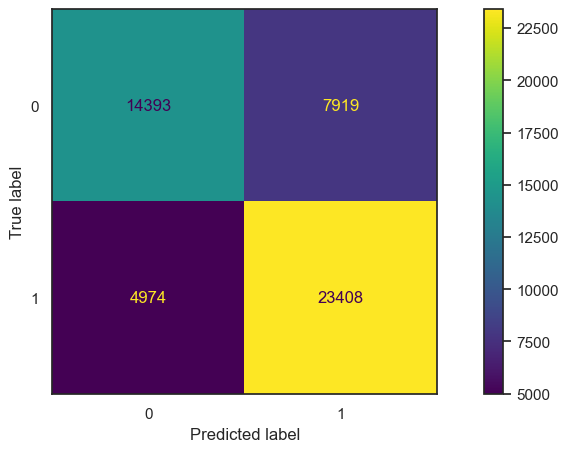

In [174]:
best_rf = RandomForestClassifier(max_depth=35, min_samples_split=0.001, n_estimators=400)

best_rf.fit(X_train, y_train)

rf_y_hat_train2 = best_rf.predict(X_train)
rf_y_hat_test2 = best_rf.predict(X_test)

print("Random Forest score for training set:", round(best_rf.score(X_train, y_train),5))
print("Random Forest score for test set:", round(best_rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, rf_y_hat_test2))

cm = confusion_matrix(y_test, rf_y_hat_test2, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_rf.classes_)
disp.plot()
plt.show()

By log-transforming features and increasing the number of trees created (n_estimators), it was possible to improve the weighted average F1 score to 0.74. Overfitting does not appear to be an issue.

Because PCA was not used, it was possible to plot feature importance (see graph below).
- Goal size is the most important feature, followed by the number of days taken from project creation to launch, and whether or not the project was a staff pick.
- Campaign length and name length were also fairly important.
- Project type (category) was less important, although whether or not a project was a technology and food project does seem to be fairly important.
- Launch and deadline time, day and month is not very important.
- Country of origin is not very important

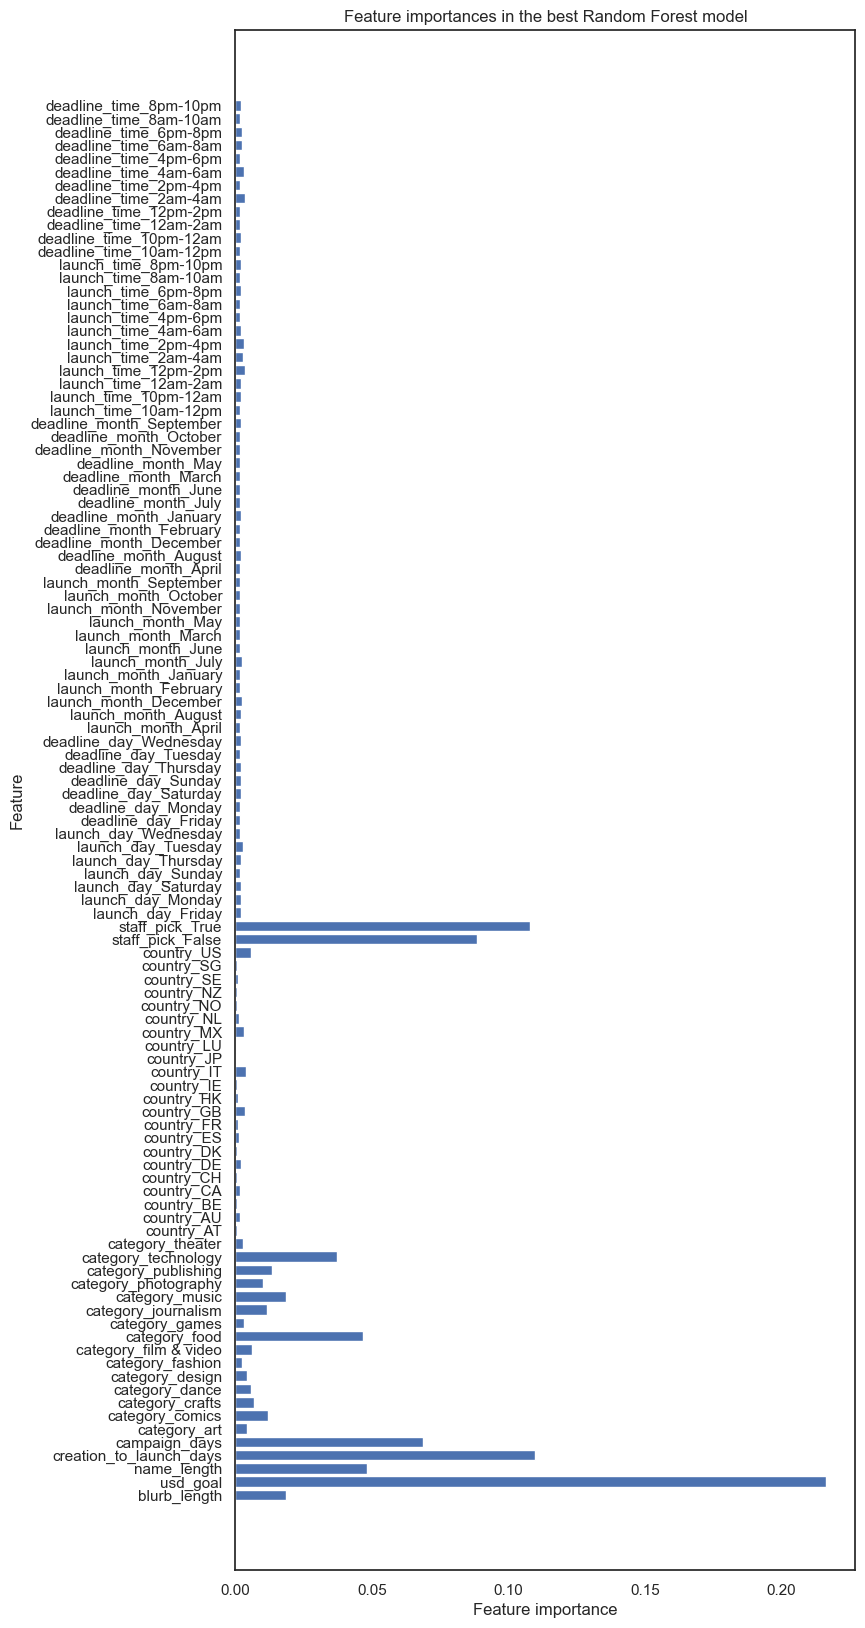

In [175]:
n_features = X_train.shape[1]
plt.figure(figsize=(8,20))
plt.barh(range(n_features), best_rf.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.title("Feature importances in the best Random Forest model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### Model 7: XGBoost without PCA

An XGBoost model will now be fitted using the log-transformed data, but without using PCA. This is to attempt to improve upon the Random Forest model, and to see whether the feature importances are similar.

In [176]:
xgb_start2 = time.time()

xgb2 = xgb.XGBClassifier(learning_rate=0.1)

params_xgb2 = [ 
  {'n_estimators': [100, 200],
   'subsample': [0.7, 0.9],
   'min_child_weight': [100, 200]
  }
]

grid_xgb2 = GridSearchCV(estimator=xgb2, param_grid=params_xgb2, cv=3)

grid_xgb2.fit(X_train, y_train)

xgb_end2 = time.time()

xgb_best_score2 = grid_xgb2.best_score_
xgb_best_params2 = grid_xgb2.best_params_

print(f"Time taken to run: {round((xgb_end2 - xgb_start2)/60,1)} minutes")
print("Best accuracy:", round(xgb_best_score2,2))
print("Best parameters:", xgb_best_params2)

Time taken to run: 0.8 minutes
Best accuracy: 0.75
Best parameters: {'min_child_weight': 100, 'n_estimators': 200, 'subsample': 0.7}


XGBoost score for training set: 0.76811
XGBoost score for test set: 0.7496

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70     22312
           1       0.75      0.82      0.79     28382

    accuracy                           0.75     50694
   macro avg       0.75      0.74      0.74     50694
weighted avg       0.75      0.75      0.75     50694



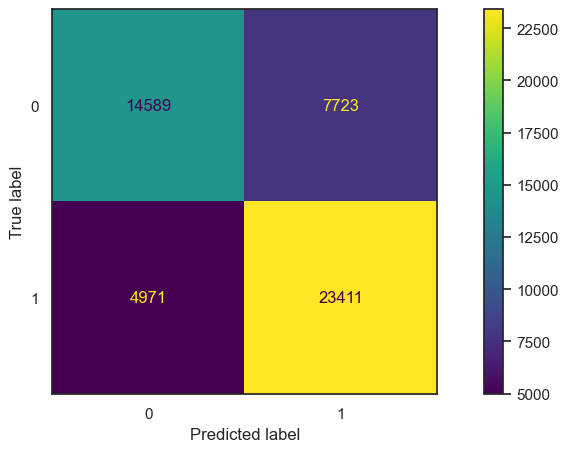

In [177]:
best_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=35, min_child_weight=100, n_estimators=100, subsample=0.7)

best_xgb.fit(X_train, y_train)

xgb_y_hat_train2 = best_xgb.predict(X_train)
xgb_y_hat_test2 = best_xgb.predict(X_test)

print("XGBoost score for training set:", round(best_xgb.score(X_train, y_train),5))
print("XGBoost score for test set:", round(best_xgb.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, xgb_y_hat_test2))

cm = confusion_matrix(y_test, xgb_y_hat_test2, labels=best_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_xgb.classes_)
disp.plot()
plt.show()

By log-transforming features it was possible to improve the weighted average F1 score to 0.75, which makes it the highest performing model so far. Overfitting does not appear to be an issue.

The graph below shows the feature importances for the model.
- Goal size is the most important feature, followed by the number of days taken from project creation to launch, followed by the name and blurb lengths.
- Campaign length was also fairly important.
- Most other categories were relatively unimportant, although project categories and whether the project was from the US are slightly important.

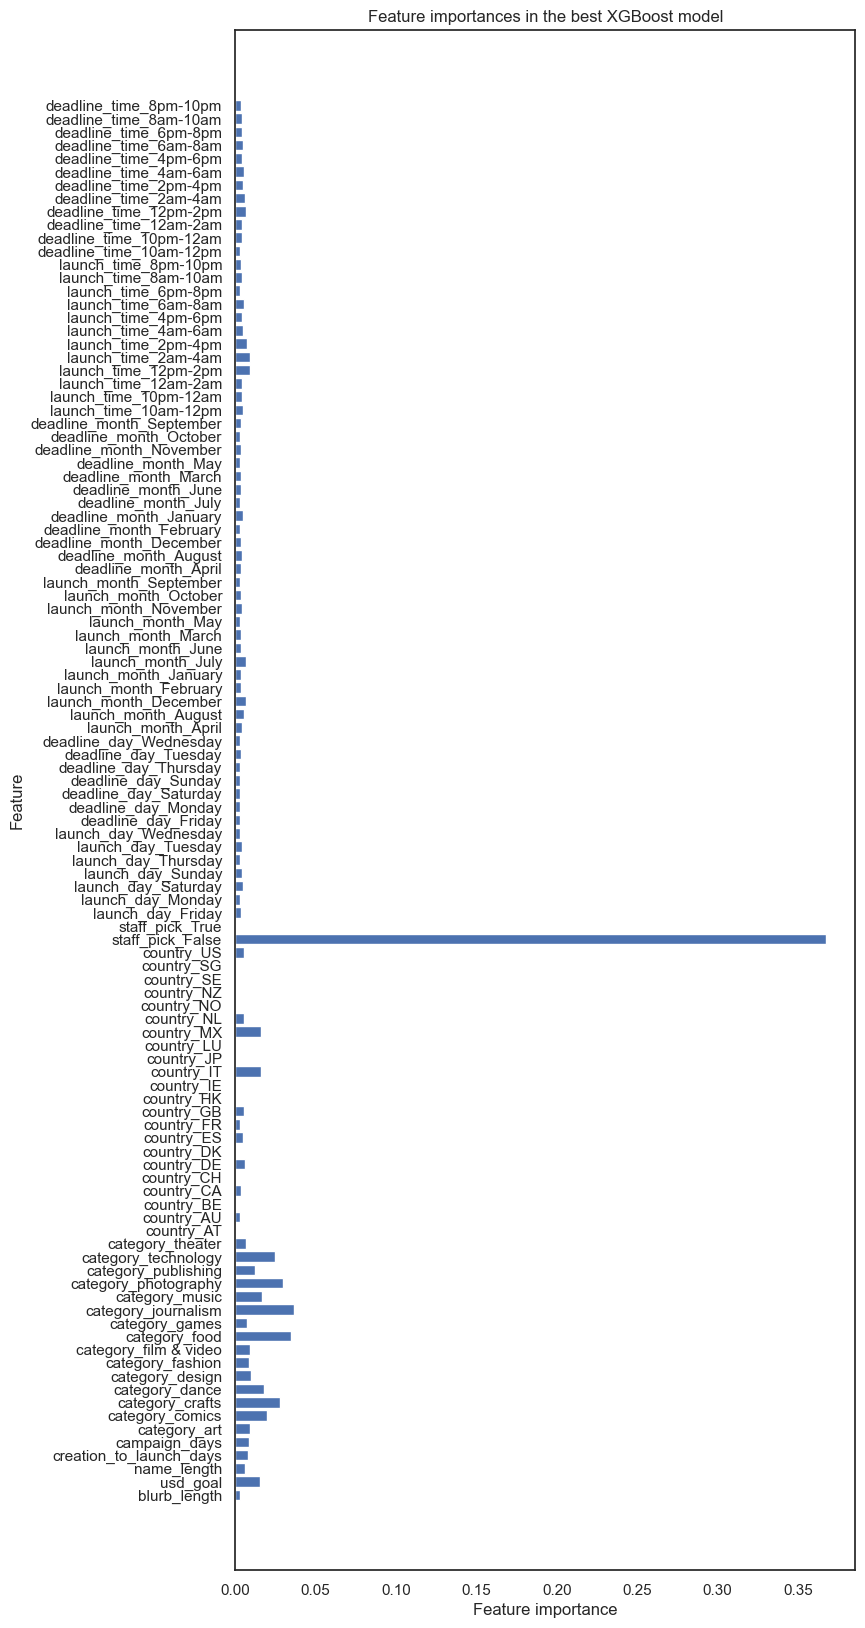

In [178]:
# Plotting feature importance
n_features = X_train.shape[1]
plt.figure(figsize=(8,20))
plt.barh(range(n_features), best_xgb.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.title("Feature importances in the best XGBoost model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

Plotting the feature importances for the Random Forest model and the XGBoost model side-by-side shows the differences between them (see graph below).
- Goal size followed by the number of days from creation to launch are the two most important features in each model.
- The main difference is in the importance of whether or not a project was a staff pick - this was very important in the Random Forest model, and not important at all in the XGBoost model.
- There are some other differences, including category being more important in Random Forests, and name and blurb length being more important in XGBoost.
- Overall, the Random Forest model seems to consider more features more important, whereas XGBoost depends more heavily on only five features.

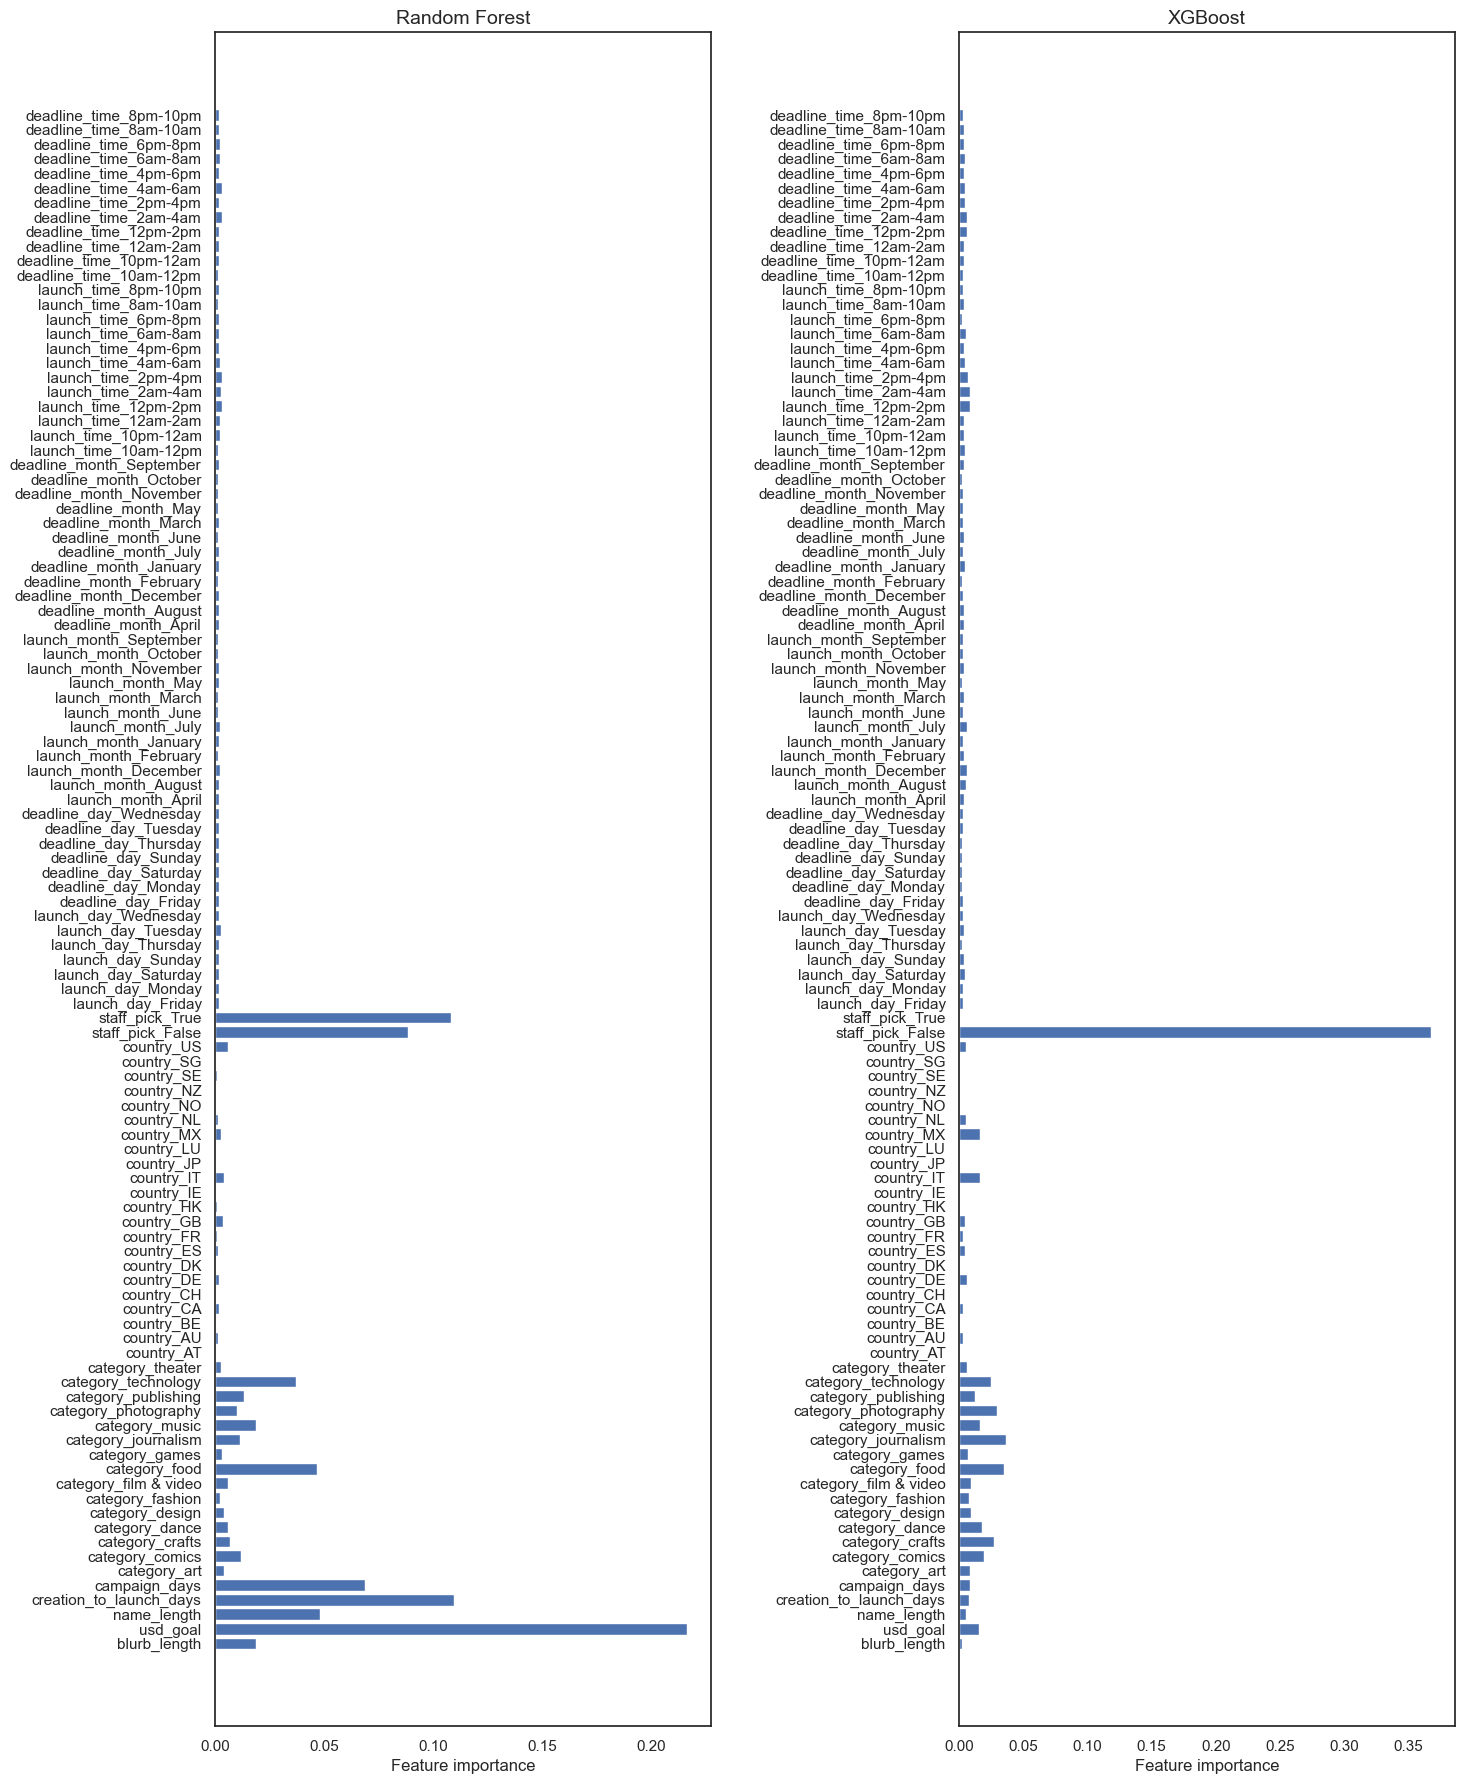

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,22))
n_features = X_train.shape[1]
ax1.barh(range(n_features), best_rf.feature_importances_, align='center')
ax1.set_yticks(np.arange(n_features))
ax1.set_yticklabels(X_train.columns.values) 
ax1.set_xlabel('Feature importance')
ax1.set_title('Random Forest', fontsize=14)
ax2.barh(range(n_features), best_xgb.feature_importances_, align='center') 
ax2.set_yticks(np.arange(n_features))
ax2.set_yticklabels(X_train.columns.values)
ax2.set_xlabel('Feature importance')
ax2.set_title('XGBoost', fontsize=14)
fig.subplots_adjust(wspace=0.5);

### Additional investigation of PCA

The graphs of feature importances above indicate that launch and deadline months, days and times are not very important to either model. Filtering out unimportant feature prior to PCA might help create a more effective PCA.

In [180]:
# Dropping columns beginning with 'deadline'
X_filtered = X_log[[c for c in X_log.columns if c[:8] != 'deadline']]

# Dropping columns beginning with 'launch'
X_filtered = X_filtered[[c for c in X_filtered.columns if c[:6] != 'launch']]

X_filtered.head()

,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,staff_pick_False,staff_pick_True
0,0.599954,-0.863064,-0.369130,0.046185,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,-0.124959,-0.065003,-0.092969,-0.109497,-0.343953,-0.062476,-0.054148,-0.103967,-0.036596,-0.015954,-0.099968,-0.093066,-0.048528,-0.06677,-0.07994,-0.052756,0.615889,0.383402,-0.383402
1,-0.804977,0.694414,0.596395,1.329281,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,-0.124959,-0.065003,-0.092969,-0.109497,-0.343953,-0.062476,-0.054148,-0.103967,-0.036596,-0.015954,-0.099968,-0.093066,-0.048528,-0.06677,-0.07994,-0.052756,0.615889,0.383402,-0.383402
2,0.800659,0.573727,0.826781,-0.134553,2.325957,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,-0.124959,-0.065003,-0.092969,-0.109497,2.907377,-0.062476,-0.054148,-0.103967,-0.036596,-0.015954,-0.099968,-0.093066,-0.048528,-0.06677,-0.07994,-0.052756,-1.623670,0.383402,-0.383402
3,1.001363,-0.270900,0.596395,-0.220362,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,-0.412689,-0.186654,2.990267,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,-0.124959,-0.065003,-0.092969,-0.109497,-0.343953,-0.062476,-0.054148,-0.103967,-0.036596,-0.015954,-0.099968,-0.093066,-0.048528,-0.06677,-0.07994,-0.052756,0.615889,0.383402,-0.383402
4,-0.202864,-0.142564,-0.369130,1.195768,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,-0.124959,-0.065003,-0.092969,-0.109497,-0.343953,-0.062476,-0.054148,-0.103967,-0.036596,-0.015954,-0.099968,-0.093066,-0.048528,-0.06677,-0.07994,-0.052756,0.615889,0.383402,-0.383402


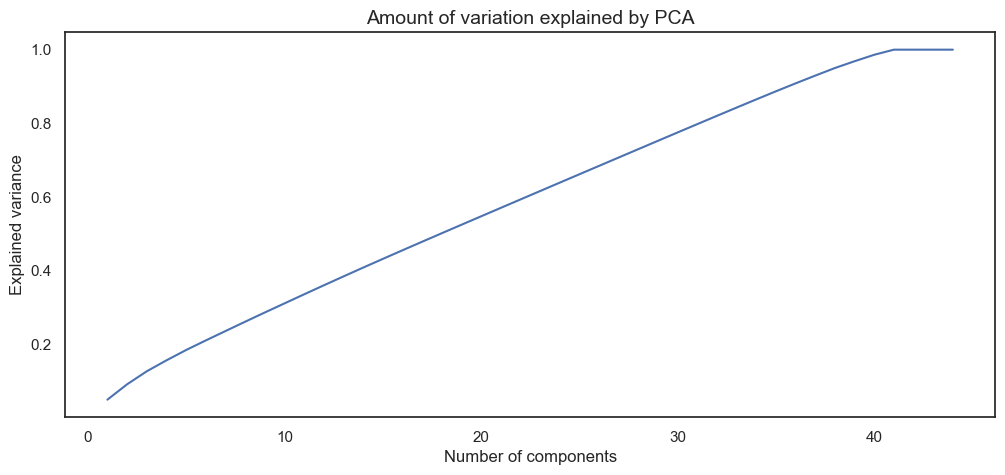

In [181]:
# Conducting PCA
pca = PCA()
principal_comps = pca.fit_transform(X_filtered)
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Plotting the amount of variation explained by PCA with different numbers of components
plt.plot(list(range(1, len(explained_var)+1)), explained_var)
plt.title('Amount of variation explained by PCA', fontsize=14)
plt.xlabel('Number of components')
plt.ylabel('Explained variance');

Unfortunately, this appears to show the same pattern as the previous PCA analysis, with no clear 'elbow' point and without the first few components explaining the majority of variation.

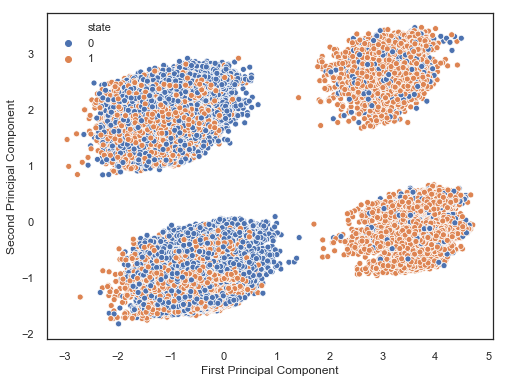

In [ ]:
# Plotting the first two principal components, coloured by target
plt.figure(figsize=(8,6))
sns.scatterplot(x=principal_comps_df.PC1, y=principal_comps_df.PC2, data=principal_comps_df, hue='state')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

The graph above reiterates the point that even the first two components do not explain much variation alone. There is also an interesting pattern in the data, although the reason is unclear.

As a final experiment, countries will also be dropped from the dataframe, as they also do not explain much variance.

In [184]:
X_filtered = X_filtered[[c for c in X_filtered.columns if c[:7] != 'country']]

X_filtered.head()

,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,staff_pick_False,staff_pick_True
0,0.599954,-0.863064,-0.369130,0.046185,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,0.383402,-0.383402
1,-0.804977,0.694414,0.596395,1.329281,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,0.383402,-0.383402
2,0.800659,0.573727,0.826781,-0.134553,2.325957,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,0.383402,-0.383402
3,1.001363,-0.270900,0.596395,-0.220362,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,-0.412689,-0.186654,2.990267,-0.34294,-0.168885,0.383402,-0.383402
4,-0.202864,-0.142564,-0.369130,1.195768,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,0.383402,-0.383402


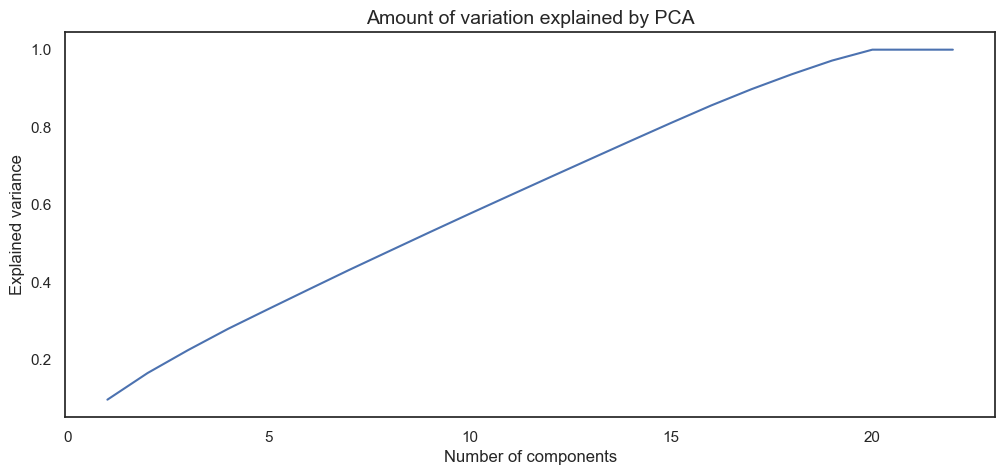

In [185]:
# Conducting PCA
pca = PCA()
principal_comps = pca.fit_transform(X_filtered)
explained_var = np.cumsum(pca.explained_variance_ratio_)

# Plotting the amount of variation explained by PCA with different numbers of components
plt.plot(list(range(1, len(explained_var)+1)), explained_var)
plt.title('Amount of variation explained by PCA', fontsize=14)
plt.xlabel('Number of components')
plt.ylabel('Explained variance');

Unfortunately this shows a similar pattern.

### Potential directions for future work

Potential additional improvements to the models include:
- Further explanation of PCA, or possibly using the original PCA but with 58 components instead, as this only had slightly lower accuracy scores in the logistic regression test case than using 90 components
- Further tuning of Random Forest and XGBoost parameters

***
# Conclusions and recommendations

### Choosing a final model

In [186]:
# Extracting weighted average precision, recall and test scores for each best model
# Logistic regression
lr_test_precision, lr_test_recall, lr_test_f1score, lr_test_support = precision_recall_fscore_support(y_test, lr_y_hat_test2, average='weighted')
lr_train_precision, lr_train_recall, lr_train_f1score, lr_train_support = precision_recall_fscore_support(y_train, lr_y_hat_train2, average='weighted')
# Random Forest
rf_test_precision, rf_test_recall, rf_test_f1score, rf_test_support = precision_recall_fscore_support(y_test, rf_y_hat_test2, average='weighted')
rf_train_precision, rf_train_recall, rf_train_f1score, rf_train_support = precision_recall_fscore_support(y_train, rf_y_hat_train2, average='weighted')
# XGBoost
xgb_test_precision, xgb_test_recall, xgb_test_f1score, xgb_test_support = precision_recall_fscore_support(y_test, xgb_y_hat_test2, average='weighted')
xgb_train_precision, xgb_train_recall, xgb_train_f1score, xgb_train_support = precision_recall_fscore_support(y_train, xgb_y_hat_train2, average='weighted')

In [187]:
# Logistic regression results
lr_results = {'Precision':[lr_train_precision, lr_test_precision], 'Recall':[lr_train_recall, lr_test_recall], 'F1_score': [lr_train_f1score, lr_test_f1score]}
lr_results = pd.DataFrame(lr_results, index=['Train', 'Test'])
print("Best logistic regression results (Model 5):")
lr_results

Best logistic regression results (Model 5):


,Precision,Recall,F1_score
Train,0.732587,0.733728,0.731823
Test,0.733060,0.734071,0.732036


In [188]:
# Random Forest results
rf_results = {'Precision':[rf_train_precision, rf_test_precision], 'Recall':[rf_train_recall, rf_test_recall], 'F1_score': [rf_train_f1score, rf_test_f1score]}
rf_results = pd.DataFrame(rf_results, index=['Train', 'Test'])
print("Best Random Forest results (Model 6):")
rf_results

Best Random Forest results (Model 6):


,Precision,Recall,F1_score
Train,0.777871,0.777394,0.775070
Test,0.745435,0.745670,0.742957


In [189]:
# XGBoost results
xgb_results = {'Precision':[xgb_train_precision, xgb_test_precision], 'Recall':[xgb_train_recall, xgb_test_recall], 'F1_score': [xgb_train_f1score, xgb_test_f1score]}
xgb_results = pd.DataFrame(xgb_results, index=['Train', 'Test'])
print("Best XGBoost results (Model 7):")
xgb_results

Best XGBoost results (Model 7):


,Precision,Recall,F1_score
Train,0.768075,0.768111,0.765914
Test,0.749265,0.749596,0.747156


### Final model evaluation and interpretation

Each model was able to achieve an accuracy of 73-75% after parameter tuning. Although it was relatively easy to reach an accuracy level of about 70% for each model, parameter tuning and other adjustments were only able to increase accuracy levels by a small amount. Possibly the  large amount of data for each of only two categories meant that there was enough data for even a relatively simple model (e.g. logistic regression with default settings) to achieve a good level of accuracy.

The final chosen model is the tuned XGBoost model, which had the highest test set weighted average F1 score of 0.747.

Interestingly, each model performed worse at predicting failures compared to successes, with a lower true negative rate than true positive rate (see calculations below). I.e. it classified quite a few failed projects as successes, but relatively few successful projects as failures. Possibly the factors that might cause a project to fail are more likely to be beyond the scope of the data, e.g. poor marketing, insufficient updates, or not replying to messages from potential backers.

The false positive and false negative rates mean that, if the data about a new project is fed through the model to make a prediction about its success or failure:
- if the project is going to end up being a success, the model will correctly predict this as a success about 80% of the time
- if the project is going to end up being a failure, the model will only correctly predict this as a failure about 65% of the time, and the rest of the time will incorrectly predict it as a success

In [190]:
r_cf = confusion_matrix(y_test, xgb_y_hat_test2)
print("Evaluation of the final model:")
print("\nIf the true value is failure, what proportion does the model correctly predict as a failure? \n(True negative rate/specificity):\n", round(r_cf[0][0]/sum(r_cf[0]),4))
print("If the true value is success, what proportion does the model correctly predict as a success? \n(True positive rate/recall/sensitivity):\n", round(r_cf[1][1]/sum(r_cf[1]),4))
print("\nIf the model predicts a failure, what proportion are actually failures? \n(Negative prediction value):\n", round(r_cf[0][0]/sum(r_cf[:,0]),4))
print("If the model predicts a success, what proportion are actually successes? \n(Positive prediction value/precision):\n", round(r_cf[1][1]/sum(r_cf[:,1]),4))

Evaluation of the final model:

If the true value is failure, what proportion does the model correctly predict as a failure? 
(True negative rate/specificity):
 0.6539
If the true value is success, what proportion does the model correctly predict as a success? 
(True positive rate/recall/sensitivity):
 0.8249

If the model predicts a failure, what proportion are actually failures? 
(Negative prediction value):
 0.7459
If the model predicts a success, what proportion are actually successes? 
(Positive prediction value/precision):
 0.7519


### Recommendations

Some of the factors that had a **positive effect** on success rate and/or the amount of money received (as deduced from a mixture of data exploration and model feature importances) are:

**Most important:**
- Smaller project goals
- Being chosen as a staff pick (a measure of quality)
- Shorter campaigns
- Taking longer between creation and launch
- Comics, dance and games projects

**Less important:**
- Projects from Hong Kong
- Film & video and music projects are popular categories on the site, and are fairly successful
- Launching on a Tuesday (although this is also the most common day to launch a project, so beware the competition)
- Launching in October
- Launching between 12pm and 2pm UTC (this is related to the country a project is launched from, but backers could come from all over the world)
- Name and blurb lengths (shorter blurbs and longer names are preferred)

Factors which had a **negative effect** on success rate and/or the amount of money received are:

**Most important:**
- Large goals
- Longer campaigns
- Food and journalism projects
- Projects from Italy

**Less important:**
- Launching on a weekend
- Launching in July or December
- Launching between 6pm and 4am UTC

Overall, Kickstarter is well suited to small, high-quality projects, particularly comics, dances and games. It is less suited to larger projects, particularly food and journalism projects.